In [8]:
import copy
import io
import os
from os.path import join
from contextlib import redirect_stdout
import sys
import math

sys.path.append('./python/')
import inversion as inv
import jacobian as j
import format_plots as fp
# import inv_plot

import xarray as xr
import numpy as np

import pandas as pd
from scipy.sparse import diags, identity
from scipy import linalg, stats

from matplotlib import colorbar, colors, rcParams
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
%matplotlib inline
c = plt.cm.get_cmap('inferno', lut=10)

def color(k, cmap='inferno', lut=10):
    c = plt.cm.get_cmap(cmap, lut=lut)
    return colors.to_hex(c(k))

def cmap_trans(cmap, ncolors=300, nalpha=20):
    color_array = plt.get_cmap(cmap)(range(ncolors))

    # change alpha values
    color_array[:,-1] = np.append(np.linspace(0.0,1.0,nalpha), np.ones(ncolors-nalpha))

    # create a colormap object
    map_object = LinearSegmentedColormap.from_list(name='plasma_trans',colors=color_array)

    return map_object

plasma_trans = cmap_trans('plasma')
plasma_trans_r = cmap_trans('plasma_r')

rcParams['text.usetex'] = True

SCALE = fp.SCALE
BASE_WIDTH = fp.BASE_WIDTH
BASE_HEIGHT = fp.BASE_HEIGHT

# Fontsizes
TITLE_FONTSIZE = fp.TITLE_FONTSIZE
SUBTITLE_FONTSIZE = fp.SUBTITLE_FONTSIZE
LABEL_FONTSIZE = fp.LABEL_FONTSIZE
TICK_FONTSIZE = fp.TICK_FONTSIZE

# Position
TITLE_LOC = fp.TITLE_LOC
CBAR_PAD = fp.CBAR_PAD
LABEL_PAD = fp.LABEL_PAD
CBAR_LABEL_PAD = fp.CBAR_LABEL_PAD

# Other font details
rcParams['font.family'] = 'serif'
rcParams['font.size'] = LABEL_FONTSIZE*SCALE
rcParams['text.usetex'] = True

# File locations
main = '/Users/hannahnesser/Documents/Harvard/Research/Reduced_Rank_Jacobian'
plots = join(main, 'plots')
code = join(main, 'python')
inputs = join(main, 'input')

# Load Data

In [9]:
# Import clusters
clusters = xr.open_dataarray(join(inputs, 'clusters_1x125.nc'))
clusters_plot = xr.open_dataarray(join(inputs, 'clusters_1x125_plot.nc'))

# Load estimated and true Jacobian
k_est = xr.open_dataarray(join(inputs, 'k_est.nc'))
k_est_sparse = xr.open_dataarray(join(inputs, 'k_est_sparse.nc'))
k_true = xr.open_dataarray(join(inputs, 'k_true.nc'))

# Load prior and error
xa = xr.open_dataarray(join(inputs, 'xa.nc'))
sa_vec = xr.open_dataarray(join(inputs, 'sa_vec.nc'))

# Load observations and error
y = xr.open_dataarray(join(inputs, 'y.nc'))
y_base = xr.open_dataarray(join(inputs, 'y_base.nc'))
so_vec = xr.open_dataarray(join(inputs, 'so_vec.nc'))

# Load the gridded emissions
emis = j.get_delta_emis(clusters_long=clusters,
                        emis_loc=join(inputs, 'base_emis.nc'))

# Load the gridded observations
obs = pd.read_csv(join(inputs, 'sat_obs.gosat.00.m'),
                  delim_whitespace=True,
                  header=0)
obs['GOSAT'] *= 1e9
obs['model'] *= 1e9
obs = obs[obs['GLINT'] == False]
obs = obs[['NNN', 'LON', 'LAT', 'GOSAT', 'model']]
obs = obs.rename(columns={'LON' : 'lon',
                          'LAT' : 'lat',
                          'NNN' : 'Nobs'})

In [10]:
clusters_plot

<xarray.DataArray (lat: 60, lon: 80)>
array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       ...,
       [1971., 1972., 1973., ...,    0.,    0.,    0.],
       [2025., 2026., 2027., ...,    0.,    0.,    0.],
       [2064.,    0., 2065., ...,    0.,    0.,    0.]])
Coordinates:
  * lat      (lat) float64 10.25 11.25 12.25 13.25 ... 66.25 67.25 68.25 69.25
  * lon      (lon) float64 -139.7 -138.4 -137.2 -135.9 ... -43.44 -42.19 -40.94

# Set Constants

In [11]:
RF = 5

# True Results

In [12]:
# Create a true Reduced Rank Jacobian object
true = inv.ReducedRankJacobian(k_true.values,
                               xa.values,
                               sa_vec.values,
                               y.values,
                               y_base.values,
                               so_vec.values)
true.xa_abs = emis*1e3
true.rf = RF

# Complete an eigendecomposition of the prior pre-
# conditioned Hessian, filling in the eigenvalue
# and eigenvector attributes of true.
true.edecomp()

# Solve the inversion, too.
true.solve_inversion()

... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -1.29e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

... Solving inversion ...
Calculating the cost function at the prior mean.
     Cost function: 297587.95
Calculating the posterior error.
Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 167286.04
     Negative cells: -445
Calculating the averaging kernel.
     DOFS: 194.90
Calculating updated modeled observations.
... Complete ...



# Initial Results

In [13]:
est0 = inv.ReducedRankJacobian(k_est.values,
                               xa.values,
                               sa_vec.values,
                               y.values,
                               y_base.values,
                               so_vec.values)
est0.xa_abs = emis *1e3
est0.rf = RF
est0.edecomp()
est0.solve_inversion()

... Initializing inversion object ...
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -3.60e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

... Solving inversion ...
Calculating the cost function at the prior mean.
     Cost function: 297587.95
Calculating the posterior error.
Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 225115.83
     Negative cells: -924
Calculating the averaging kernel.
     DOFS: 161.53
Calculating updated modeled observations.
... Complete ...



# Standard Update
## (Signal-to-noise ratio or percentage of information content)

In [14]:
# First set of updates
est1 = est0.update_jacobian(true.k, 
                            snr=1.25)

# Second set
est2 = est1.update_jacobian(true.k, 
                            rank=est0.get_rank(pct_of_info=0.975))

Calculating prolongation and reduction.
Calculated rank from signal-to-noise ratio : 102
... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -5.65e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

... Solving inversion ...
Calculating the cost function at the prior mean.
     Cost function: 297587.95
Calculating the posterior error.
Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 189780.51
     Negative cells: -179
Calculating the averaging kernel.
     DOFS: 67.08
Calculating updated modeled observations.
... Complete ...

Calculated rank from percent of information: 446
Calculating prolongation and reduction.
Using defined rank: 446
... Initializing inversion object ...
Forcing negative val

# Convergence update

In [7]:
# # for i in range(est0.nstate):
# dist = np.array([])
# dofs = np.array([])
# xprev = copy.deepcopy(est0.xhat)
# xhats = xprev.reshape((-1, 1))
# trap = io.StringIO()
# for i in range(1, est0.nstate+1):
#     if i%100 == 0:
#         print(i)
#     with redirect_stdout(trap):
#         xnext = est0.update_jacobian(true.k, rank=i)
#         dofsnext = np.trace(xnext.a)
#         xnext = xnext.xhat
#     dist = np.append(dist, np.linalg.norm(xnext - xprev, ord=1))
#     dofs = np.append(dofs, dofsnext)
#     xhats = np.append(xhats, xnext.reshape((-1, 1)), axis=1)
#     xprev = copy.deepcopy(xnext)

(0, 2098)

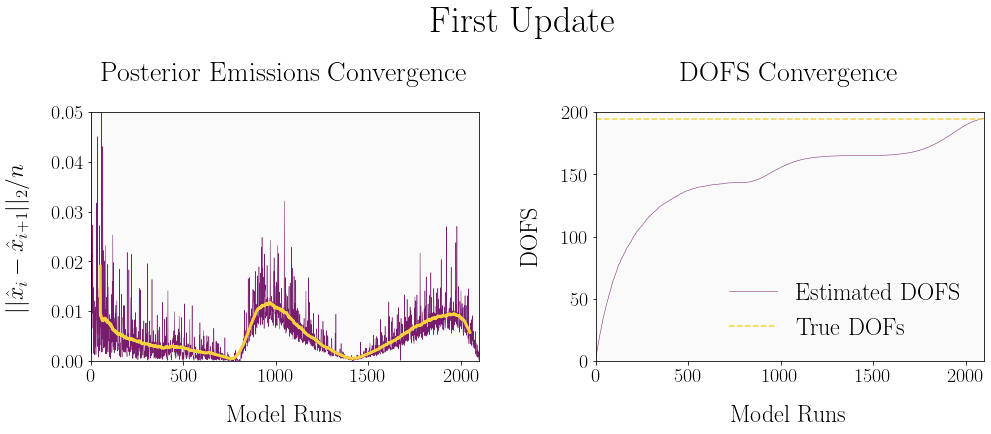

In [30]:
fig, ax = fp.get_figax(aspect=1.75, rows=1, cols=2)
fig.suptitle('First Update', fontsize=TITLE_FONTSIZE*SCALE, y=1.2)
plt.subplots_adjust(wspace=0.3)

# Convergence of posterior emissions
ax[0] = fp.add_title(ax[0], 'Posterior Emissions Convergence', 
                     fontsize=SUBTITLE_FONTSIZE*SCALE)
ax[0] = fp.add_labels(ax[0], 'Model Runs', r'$\vert\vert\hat{x}_i - \hat{x}_{i+1}\vert\vert_2/n$')
dist2_ma = np.array(pd.Series(dist).rolling(window=100, center=True).mean())
ax[0].plot(dist/est0.nstate, c=color(3), lw=0.5, label='Difference')
ax[0].plot(dist_ma/est0.nstate, c=color(8), lw=3, label='Rolling Mean')
ax[0].set_ylim(0, 0.05)
ax[0].set_xlim(0, 2098)

# Convergence of DOFS
ax[1] = fp.add_title(ax[1], 'DOFS Convergence',
                     fontsize=SUBTITLE_FONTSIZE*SCALE)
ax[1] = fp.add_labels(ax[1], 'Model Runs', 'DOFS')
ax[1].plot(dofs, c=color(3), lw=0.5, label='Estimated DOFS')
ax[1].axhline(true.dofs.sum(), c=color(8), ls='--', label='True DOFs')
ax[1] = fp.add_legend(ax[1])
ax[1].set_ylim(0, 200)
ax[1].set_xlim(0, 2098)

In [8]:
# # for i in range(est0.nstate):
# dist2 = np.array([])
# dofs2 = np.array([])
# xprev = copy.deepcopy(est1.xhat)
# xhats2 = xprev.reshape((-1, 1))
# trap = io.StringIO()
# for i in range(1, est1.nstate+1):
#     if i%100 == 0:
#         print(i)
#     with redirect_stdout(trap):
#         xnext = est1.update_jacobian(true.k, rank=i)
#         dofsnext = np.trace(xnext.a)
#         xnext = xnext.xhat
#     dist2 = np.append(dist2, np.linalg.norm(xnext - xprev, ord=1))
#     dofs2 = np.append(dofs2, dofsnext)
#     xhats2 = np.append(xhats2, xnext.reshape((-1, 1)), axis=1)
#     xprev = copy.deepcopy(xnext)

(0, 2098)

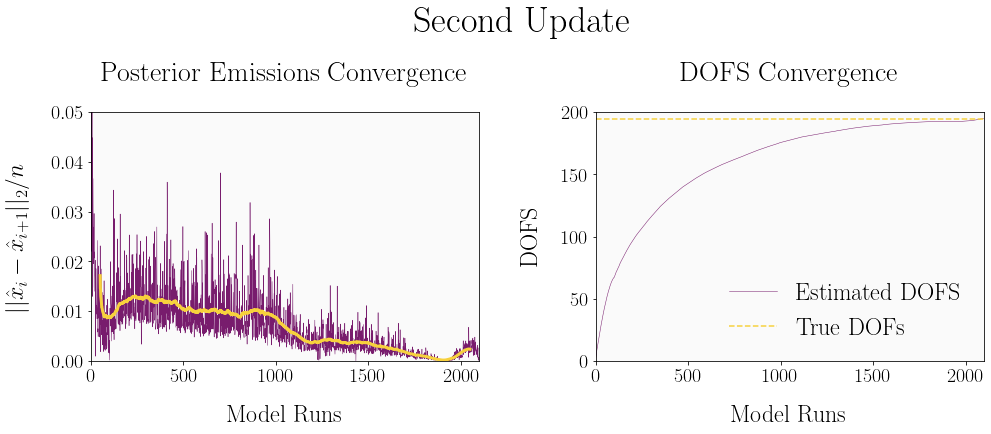

In [31]:
fig, ax = fp.get_figax(aspect=1.75, rows=1, cols=2)
fig.suptitle('Second Update', fontsize=TITLE_FONTSIZE*SCALE, y=1.2)
plt.subplots_adjust(wspace=0.3)

# Convergence of posterior emissions
ax[0] = fp.add_title(ax[0], 'Posterior Emissions Convergence', 
                     fontsize=SUBTITLE_FONTSIZE*SCALE)
ax[0] = fp.add_labels(ax[0], 'Model Runs', r'$\vert\vert\hat{x}_i - \hat{x}_{i+1}\vert\vert_2/n$')
dist2_ma = np.array(pd.Series(dist2).rolling(window=100, center=True).mean())
ax[0].plot(dist2/est0.nstate, c=color(3), lw=0.5, label='Difference')
ax[0].plot(dist2_ma/est0.nstate, c=color(8), lw=3, label='Rolling Mean')
ax[0].set_ylim(0, 0.05)
ax[0].set_xlim(0, 2098)

# Convergence of DOFS
ax[1] = fp.add_title(ax[1], 'DOFS Convergence',
                     fontsize=SUBTITLE_FONTSIZE*SCALE)
ax[1] = fp.add_labels(ax[1], 'Model Runs', 'DOFS')
ax[1].plot(dofs2, c=color(3), lw=0.5, label='Estimated DOFS')
ax[1].axhline(true.dofs.sum(), c=color(8), ls='--', label='True DOFs')
ax[1] = fp.add_legend(ax[1])
ax[1].set_ylim(0, 200)
ax[1].set_xlim(0, 2098)

# Multiscale Grid

In [7]:
test1 = est0.update_jacobian_ms(forward_model=true.k, 
                                clusters_plot=clusters_plot,
                                n_cells=[100, 200],
                                n_cluster_size=[1, 2])

... Initializing inversion object ...
... Complete ...

Number of clusters: 1
Cluster size: 1
Maximum number of grid boxes in a cluster: 1
Number of clusters: 1
Cluster size: 2
Maximum number of grid boxes in a cluster: 2
Number of state vector elements: 2
... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -9.83e-15. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

... Solving inversion ...
Calculating the cost function at the prior mean.
     Cost function: 297587.95
Calculating the posterior error.
Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 219552.62
     Negative cells: -864
Calculating the averaging kernel.
     DOFS: 160.71
Calculating updated modeled observations.
... Complete ...



(<Figure size 1152x895.221 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x1c2b849da0>)

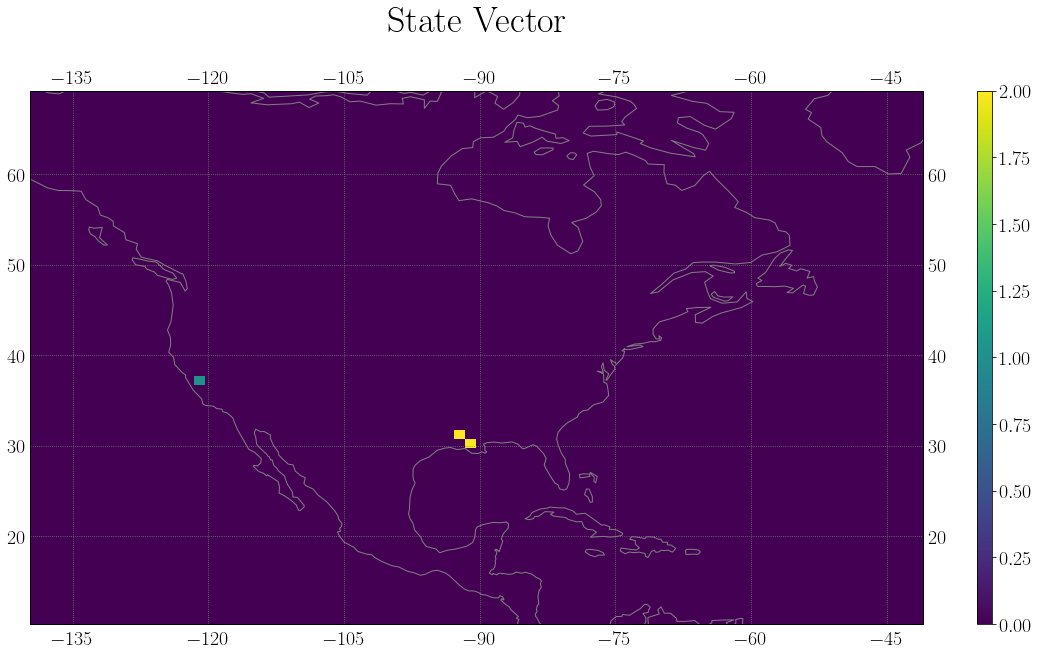

In [10]:
test1.plot_state('state_vector', clusters_plot, title='State Vector')

# OLD PLOTS TO BE UPDATED

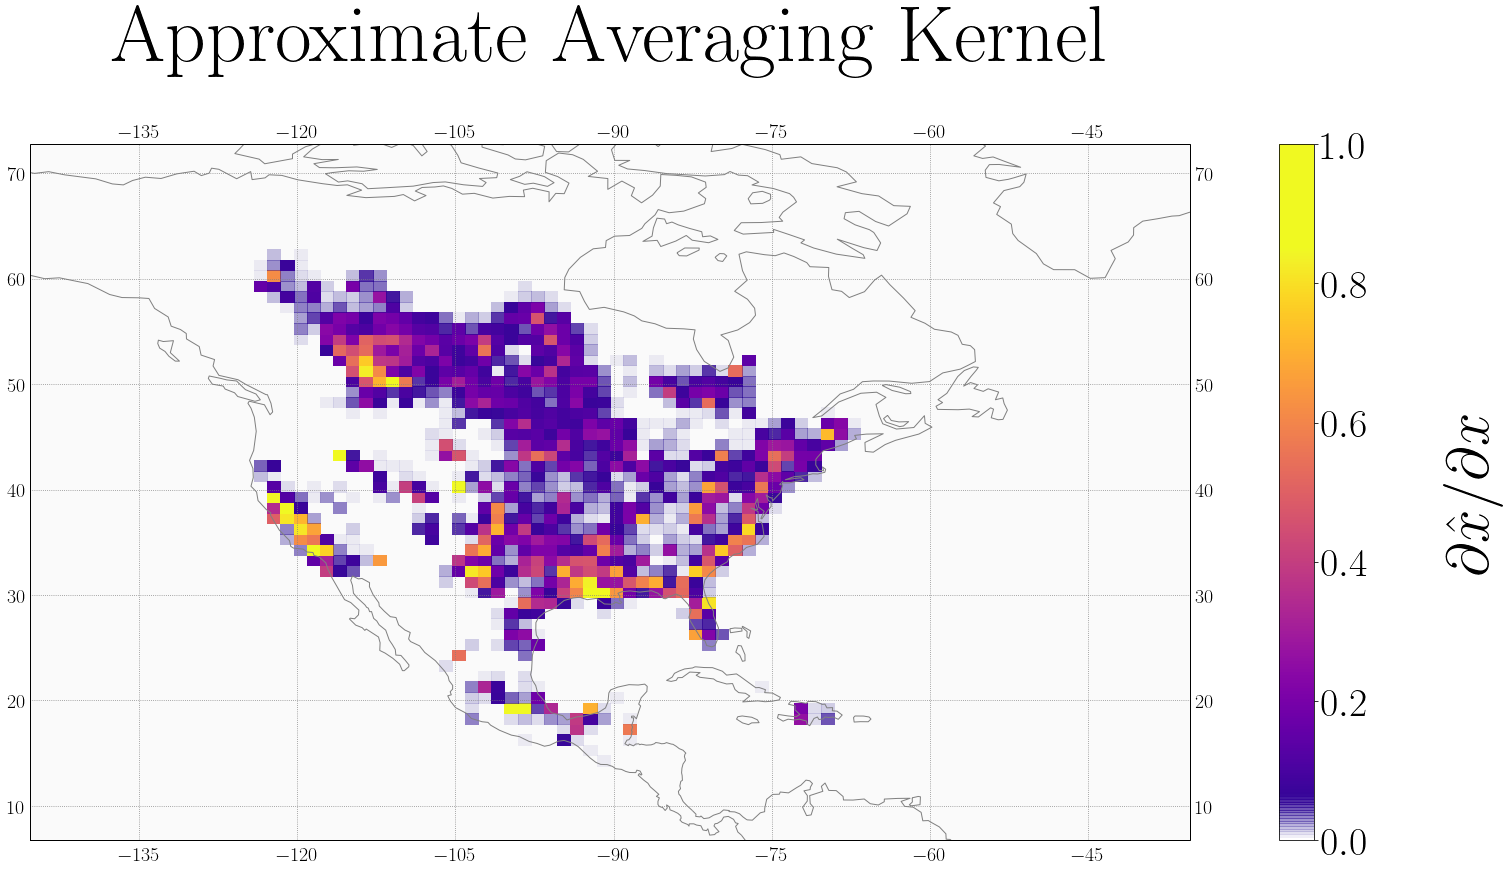

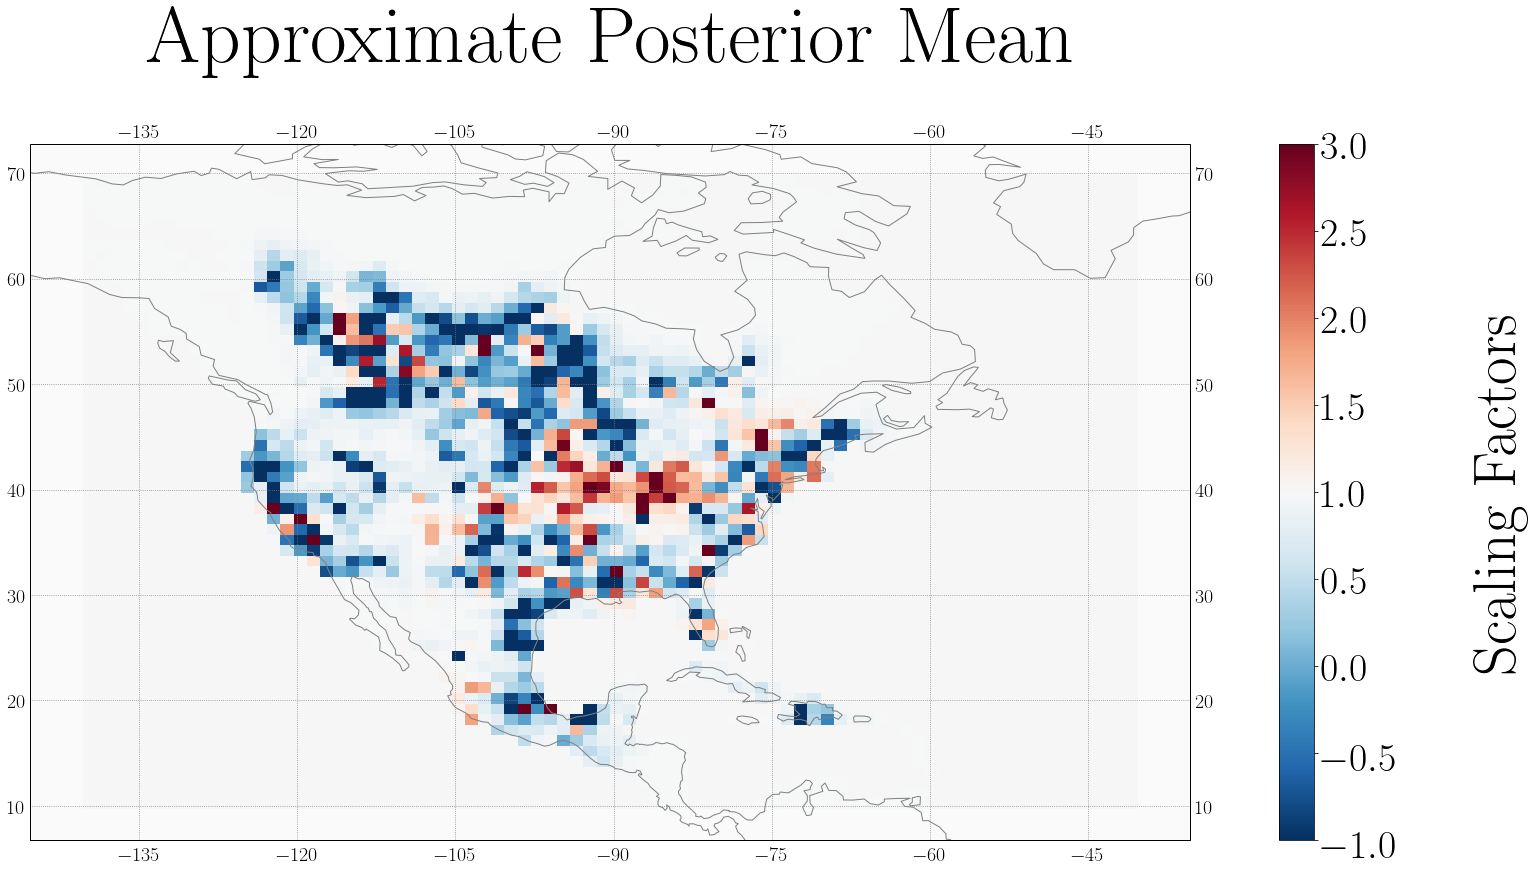

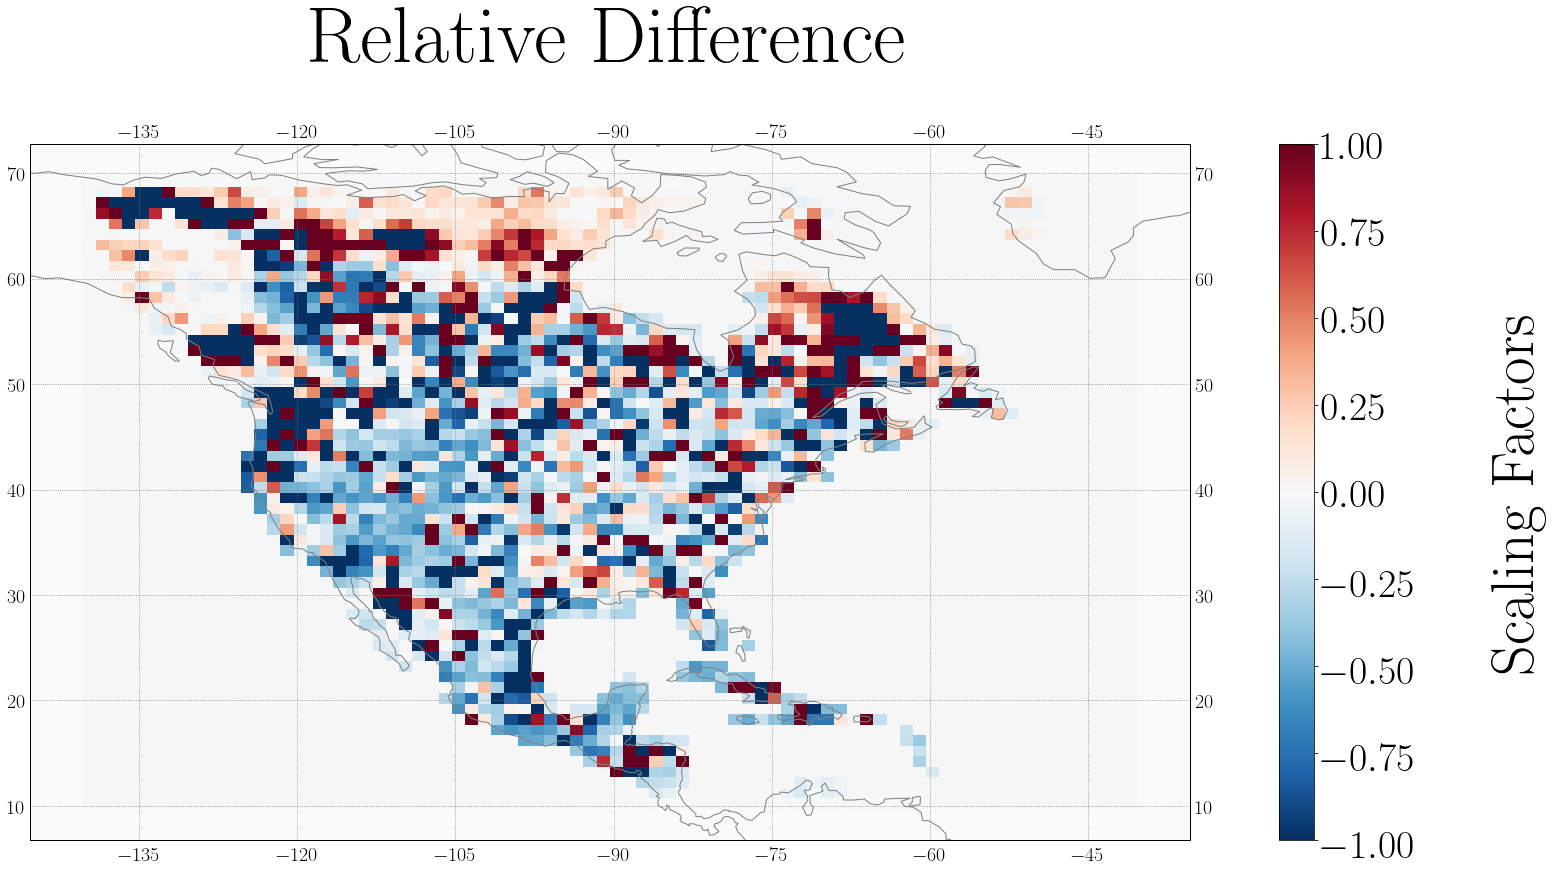

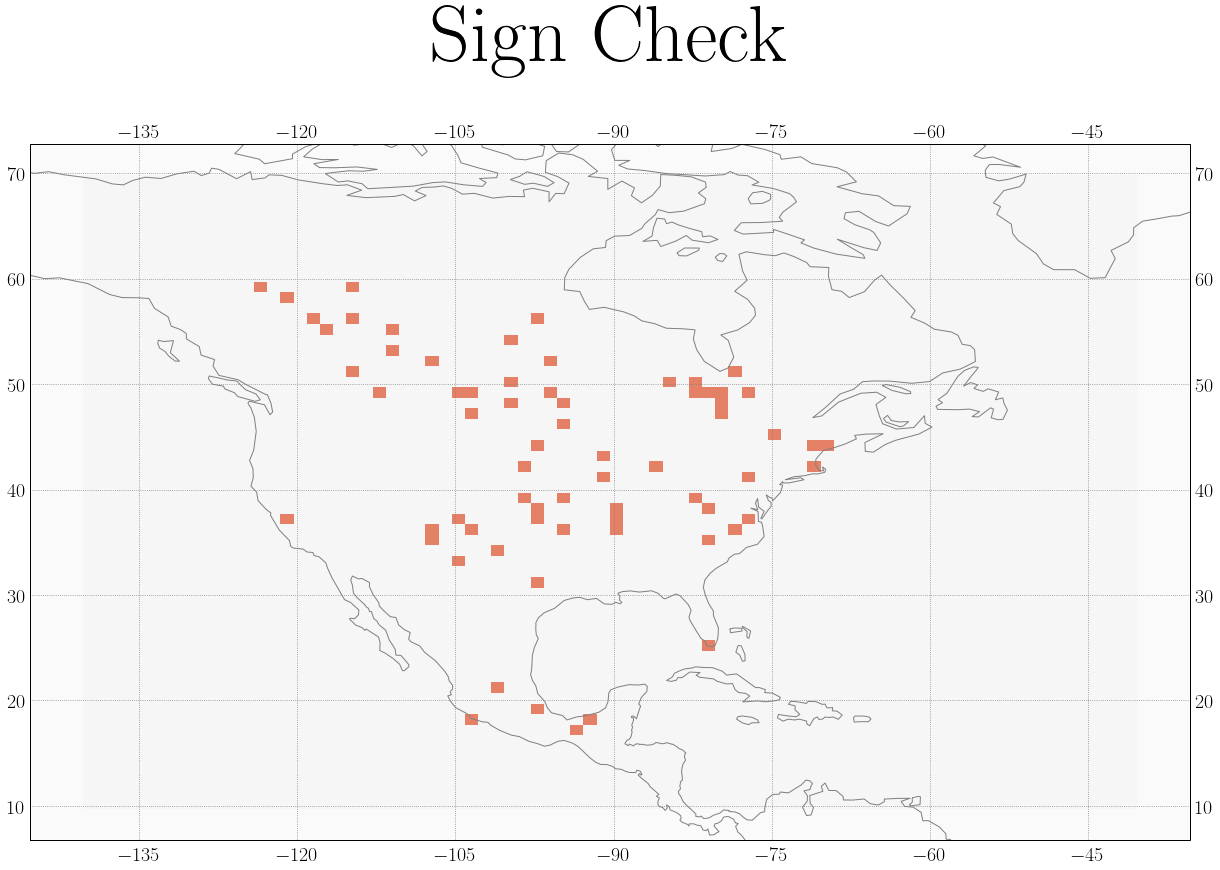

In [43]:
est2.dofs = np.diag(est2.a)
fig, ax, c = est2.plot_state('dofs', 
                               clusters_plot, 
                               default_value=0,
                               **{'title' : 'Approximate Averaging Kernel',
                                'cmap' : plasma_trans,
                                'add_colorbar' : False,
                                'vmin' : 0,
                                'vmax' : 1})
c.set_label(r'$\partial\hat{x}/\partial x$',
            fontsize=(BASEFONT+5)*SCALE,
            labelpad=75)

fig, ax, c = est2.plot_state('xhat', 
                               clusters_plot, 
                               default_value=1,
                               **{'title' : 'Approximate Posterior Mean',
                                  'cmap' : 'RdBu_r',
                                  'vmin' : -1,
                                  'vmax' : 3})
c.set_label('Scaling Factors', 
            fontsize=(BASEFONT+5)*SCALE, 
            labelpad=75)

est2.xhat_diff = est2.xhat - true.xhat
est2.xhat_diff_rel = (est2.xhat - true.xhat)/true.xhat

fig, ax, c = est2.plot_state('xhat_diff_rel', 
                               clusters_plot, 
                               default_value=0,
                               **{'title' : 'Relative Difference',
                                  'cmap' : 'RdBu_r',
                                  'vmin' : -1,
                                  'vmax' : 1,
                                  'add_colorbar' : False})
c.set_label('Scaling Factors', 
            fontsize=(BASEFONT+5)*SCALE, 
            labelpad=75)

# est2.xhat_shift = est2.xhat - 1
# true.xhat_shift = true.xhat - 1
# est2.xhat_sign_check = est2.xhat_shift*true.xhat_shift
correct_sign = (((est2.xhat > 1) & (true.xhat > 1)) |
                ((est2.xhat < 1) & (true.xhat < 1)))
est2.xhat_sign_check = np.ones(est2.nstate) # all wrong signs
est2.xhat_sign_check[correct_sign] = 0 # set correct signs to 0
est2.xhat_sign_check[~mask] = 0 # set small values of avker to 0
 
fig, ax, c = est2.plot_state('xhat_sign_check', 
                             clusters_plot, 
                             default_value=0,
                             cbar=False,
                               **{'title' : 'Sign Check',
                                  'cmap' : 'RdBu_r',
                                  'vmin' : -2,
                                  'vmax' : 2,
                                  'add_colorbar' : False})


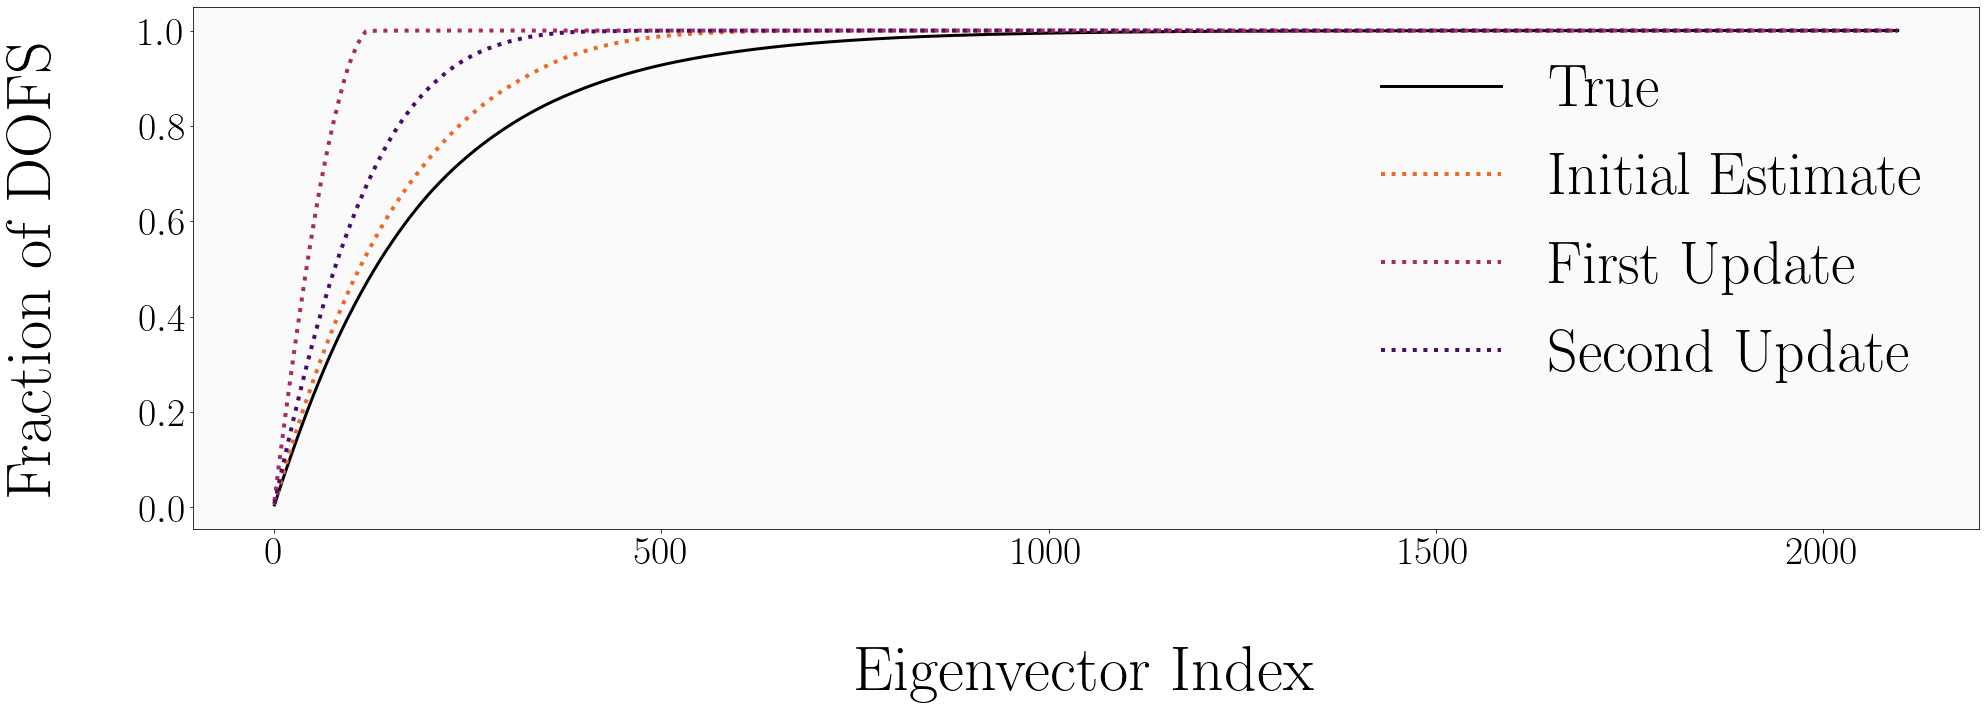

In [47]:
fig, ax = plt.subplots(figsize=(10*SCALE/1.25, 3*SCALE/1.25))
fig, ax = true.plot_info_frac(figax=[fig, ax],
                               label='True',
                               color=color(0),
                               text=False)
est0.plot_info_frac(figax=[fig, ax],
                    label='Initial Estimate',
                    ls=':', lw=4,
                    color=color(6),
                    text=False)
est1.plot_info_frac(figax=[fig, ax],
                    label='First Update',
                    ls=':', lw=4,
                    color=color(4),
                    text=False)
est2.plot_info_frac(figax=[fig, ax],
                    label='Second Update',
                    ls=':', lw=4,
                    color=color(2),
                    text=False)
ax.set_ylabel('Fraction of DOFS', fontsize=(BASEFONT+6)*SCALE,
              labelpad=LABEL_PAD)
ax.set_xlabel('Eigenvector Index', fontsize=(BASEFONT+6)*SCALE,
              labelpad=LABEL_PAD)
ax.tick_params(axis='both', which='both', labelsize=BASEFONT*SCALE)

Text(-0.3, 0.5, 'Second\nUpdate')

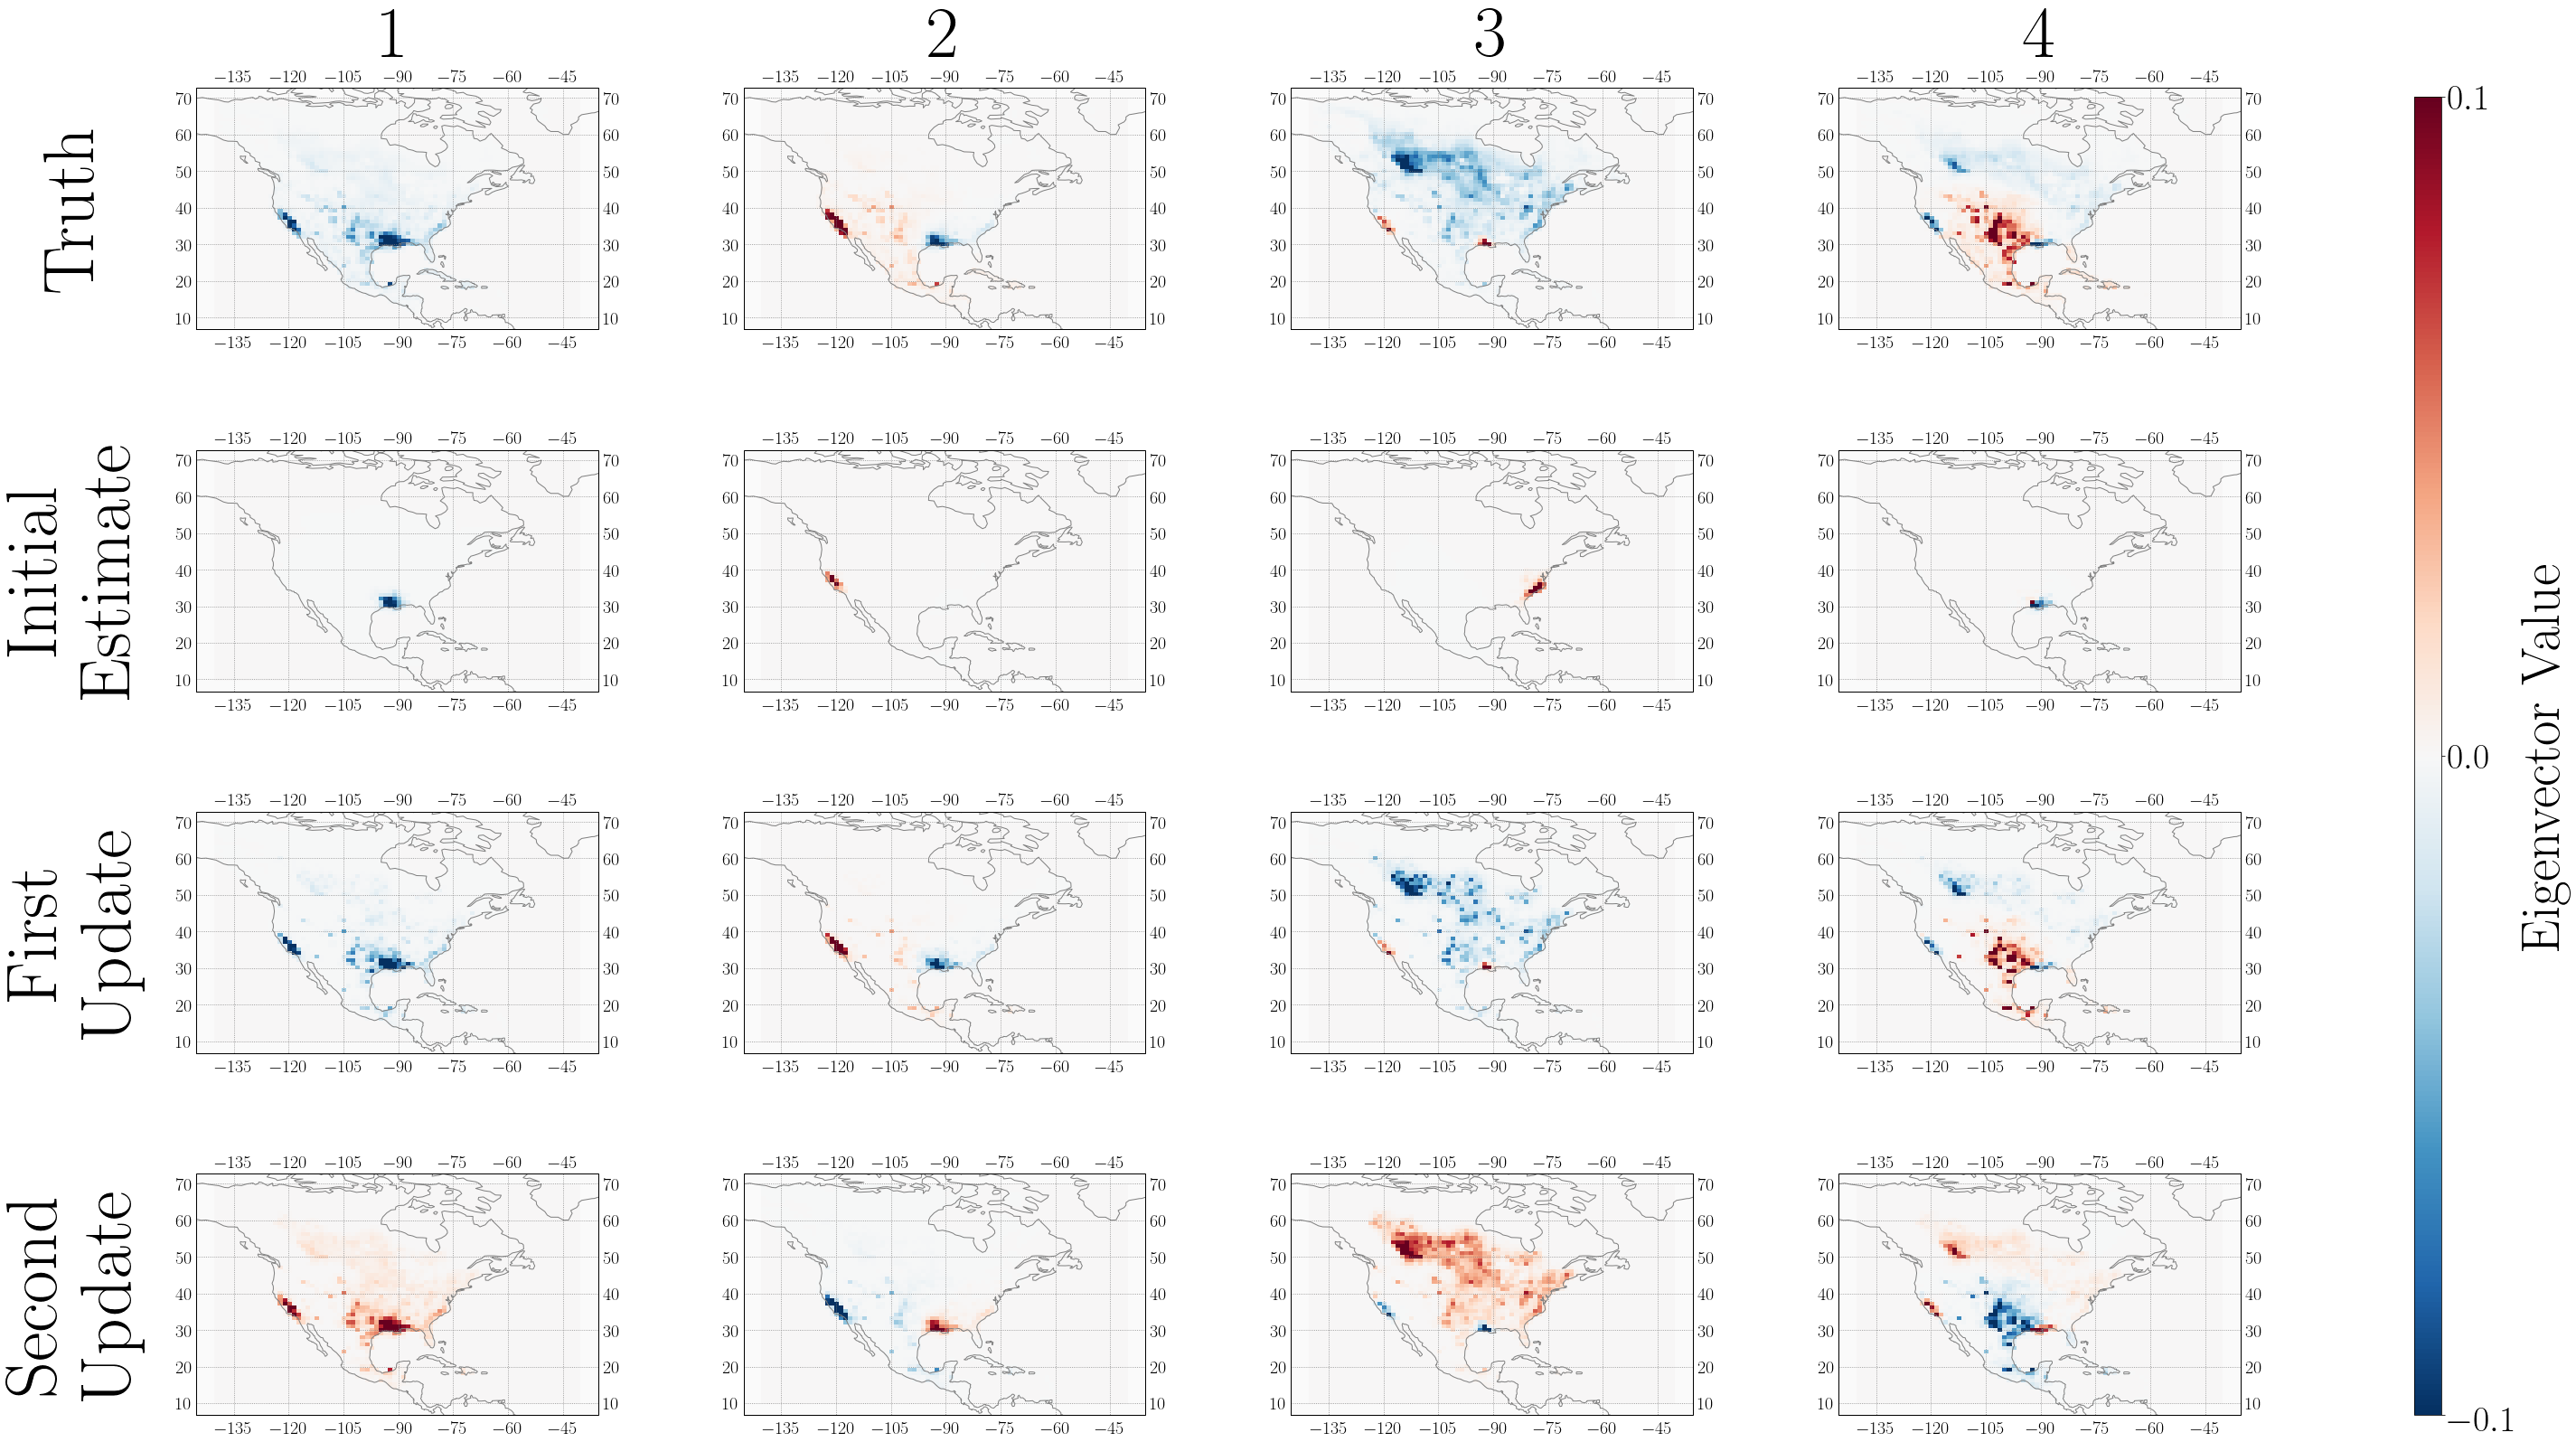

In [26]:
# Plot the first few eigenvectors to give an idea of the
# eigenspace
nx = 4
ny = 4
plot_data = [('evecs', i) for i in range(ny)]
titles = ['%d' % (i+1) for i in range(ny)]

kw = {'vmin' : -0.1,
      'vmax' : 0.1,
      'cmap' : 'RdBu_r',
      'add_colorbar' : False}
cbar_kwargs = {'ticks' : [-0.1, 0, 0.1]}

fig3, ax = plt.subplots(nx, ny, figsize=(ny*2*5.25,nx*6.75),
                       subplot_kw={'projection' : ccrs.PlateCarree()})
plt.subplots_adjust(hspace=0.5, wspace=0.15)
cax = fig3.add_axes([0.95, 0.25/2, 0.01, 0.75])


for i in range(ny):
    kw['title'] = titles[i]
    kw['figax'] = [fig3, ax[0, i]]
    fig3, ax[0, i], c = true.plot_state(plot_data[i], clusters_plot,
                                        cbar=False, **kw)
    
    kw['title'] = ''
    kw['figax'] = [fig3, ax[1, i]]
    fig3, ax[1, i], c = est0.plot_state(plot_data[i], clusters_plot, 
                                        cbar=False, **kw)

    kw['figax'] = [fig3, ax[2, i]]
    fig3, ax[2, i], c = est1.plot_state(plot_data[i], clusters_plot, 
                                        cbar=False, **kw)
    
    kw['figax'] = [fig3, ax[3, i]]
    fig3, ax[3, i], c = est2.plot_state(plot_data[i], clusters_plot, 
                                        cbar=False, **kw)

    
for axis in ax.flatten():
    axis.set_title(axis.get_title(), fontsize=(BASEFONT+10)*SCALE)

fig3.colorbar(c, cax=cax, **cbar_kwargs)
cax.tick_params(labelsize=40)
cax.set_ylabel('Eigenvector Value', fontsize=(BASEFONT+5)*SCALE)

# Add label
ax[0, 0].text(-0.3, 0.5, 'Truth', fontsize=(BASEFONT+10)*SCALE,
              rotation=90, ha='center', va='center',
              transform=ax[0,0].transAxes)
ax[1, 0].text(-0.3, 0.5, 'Initial\nEstimate', fontsize=(BASEFONT+10)*SCALE,
              rotation=90, ha='center', va='center',
              transform=ax[1,0].transAxes)
ax[2, 0].text(-0.3, 0.5, 'First\nUpdate', fontsize=(BASEFONT+10)*SCALE,
              rotation=90, ha='center', va='center',
              transform=ax[2,0].transAxes)
ax[3, 0].text(-0.3, 0.5, 'Second\nUpdate', fontsize=(BASEFONT+10)*SCALE,
              rotation=90, ha='center', va='center',
              transform=ax[3,0].transAxes)


In [15]:
r2_summ = np.zeros((10, 10))
nc_summ = np.zeros((10, 10))
nm_summ = np.zeros((10, 10))
dofs_summ = np.zeros((10, 10))
for first_update in range(100, 1100, 100):
    for second_update in range(100, 1100, 100):
        est1 = est0.update_jacobian(true.k, rank=first_update)
        est2 = est1.update_jacobian(true.k, rank=second_update)
        mask = np.diag(est2.a) > 0.005
        est2_f, true_f = est2.filter(true, mask)
        _, _, r = est2_f.calc_stats(true_f.xhat, est2_f.xhat)
        
        col = int(first_update/100 - 1)
        row = int(second_update/100 - 1)
        
        r2_summ[row, col] = r**2
        nc_summ[row, col] = len(est2_f.xhat)
        nm_summ[row, col] = est2_f.model_runs
        dofs_summ[row, col] = np.trace(est2_f.a)

Calculating prolongation and reduction.
Using defined rank: 100
... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -3.66e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

... Solving inversion ...
Calculating the cost function at the prior mean.
     Cost function: 297587.95
Calculating the posterior error.
Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 189927.98
     Negative cells: -178
Calculating the averaging kernel.
     DOFS: 66.24
Calculating updated modeled observations.
... Complete ...

Calculating prolongation and reduction.
Using defined rank: 100
... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposi

Calculated PPH.
Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -3.66e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

... Solving inversion ...
Calculating the cost function at the prior mean.
     Cost function: 297587.95
Calculating the posterior error.
Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 189927.98
     Negative cells: -178
Calculating the averaging kernel.
     DOFS: 66.24
Calculating updated modeled observations.
... Complete ...

Calculating prolongation and reduction.
Using defined rank: 600
... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -3.99e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... C

Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 179739.51
     Negative cells: -246
Calculating the averaging kernel.
     DOFS: 98.03
Calculating updated modeled observations.
... Complete ...

Calculating prolongation and reduction.
Using defined rank: 100
... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -3.60e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

... Solving inversion ...
Calculating the cost function at the prior mean.
     Cost function: 297587.95
Calculating the posterior error.
Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 182014.26
     Negative cells: -191
Calculating the averaging kernel.
     DOFS: 73.61
Calc

... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -2.67e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

... Solving inversion ...
Calculating the cost function at the prior mean.
     Cost function: 297587.95
Calculating the posterior error.
Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 171802.94
     Negative cells: -329
Calculating the averaging kernel.
     DOFS: 155.15
Calculating updated modeled observations.
... Complete ...

Calculating prolongation and reduction.
Using defined rank: 200
... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Negative 

Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -2.66e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

... Solving inversion ...
Calculating the cost function at the prior mean.
     Cost function: 297587.95
Calculating the posterior error.
Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 179777.45
     Negative cells: -206
Calculating the averaging kernel.
     DOFS: 74.85
Calculating updated modeled observations.
... Complete ...

Calculating prolongation and reduction.
Using defined rank: 300
... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -5.41e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

...

Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 170077.40
     Negative cells: -346
Calculating the averaging kernel.
     DOFS: 157.94
Calculating updated modeled observations.
... Complete ...

Calculating prolongation and reduction.
Using defined rank: 300
... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -5.41e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

... Solving inversion ...
Calculating the cost function at the prior mean.
     Cost function: 297587.95
Calculating the posterior error.
Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 176008.72
     Negative cells: -300
Calculating the averaging kernel.
     DOFS: 117.38
Ca

Calculating prolongation and reduction.
Using defined rank: 400
... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -1.84e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

... Solving inversion ...
Calculating the cost function at the prior mean.
     Cost function: 297587.95
Calculating the posterior error.
Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 173864.70
     Negative cells: -330
Calculating the averaging kernel.
     DOFS: 129.13
Calculating updated modeled observations.
... Complete ...

Calculating prolongation and reduction.
Using defined rank: 200
... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecompos

Calculated PPH.
Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -1.84e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

... Solving inversion ...
Calculating the cost function at the prior mean.
     Cost function: 297587.95
Calculating the posterior error.
Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 173864.70
     Negative cells: -330
Calculating the averaging kernel.
     DOFS: 129.13
Calculating updated modeled observations.
... Complete ...

Calculating prolongation and reduction.
Using defined rank: 700
... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -1.02e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... 

Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 172487.32
     Negative cells: -353
Calculating the averaging kernel.
     DOFS: 137.04
Calculating updated modeled observations.
... Complete ...

Calculating prolongation and reduction.
Using defined rank: 200
... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -1.84e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

... Solving inversion ...
Calculating the cost function at the prior mean.
     Cost function: 297587.95
Calculating the posterior error.
Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 173324.92
     Negative cells: -288
Calculating the averaging kernel.
     DOFS: 111.41
Ca

... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -1.96e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

... Solving inversion ...
Calculating the cost function at the prior mean.
     Cost function: 297587.95
Calculating the posterior error.
Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 169021.37
     Negative cells: -365
Calculating the averaging kernel.
     DOFS: 161.99
Calculating updated modeled observations.
... Complete ...

Calculating prolongation and reduction.
Using defined rank: 500
... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Negative 

Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -1.52e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

... Solving inversion ...
Calculating the cost function at the prior mean.
     Cost function: 297587.95
Calculating the posterior error.
Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 172904.19
     Negative cells: -284
Calculating the averaging kernel.
     DOFS: 112.00
Calculating updated modeled observations.
... Complete ...

Calculating prolongation and reduction.
Using defined rank: 600
... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -2.44e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

..

Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 169794.47
     Negative cells: -360
Calculating the averaging kernel.
     DOFS: 154.92
Calculating updated modeled observations.
... Complete ...

Calculating prolongation and reduction.
Using defined rank: 600
... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -2.44e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

... Solving inversion ...
Calculating the cost function at the prior mean.
     Cost function: 297587.95
Calculating the posterior error.
Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 171801.61
     Negative cells: -368
Calculating the averaging kernel.
     DOFS: 140.86
Ca

Calculating prolongation and reduction.
Using defined rank: 700
... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -2.64e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

... Solving inversion ...
Calculating the cost function at the prior mean.
     Cost function: 297587.95
Calculating the posterior error.
Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 171536.19
     Negative cells: -369
Calculating the averaging kernel.
     DOFS: 142.85
Calculating updated modeled observations.
... Complete ...

Calculating prolongation and reduction.
Using defined rank: 300
... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecompos

Calculated PPH.
Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -2.64e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

... Solving inversion ...
Calculating the cost function at the prior mean.
     Cost function: 297587.95
Calculating the posterior error.
Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 171536.19
     Negative cells: -369
Calculating the averaging kernel.
     DOFS: 142.85
Calculating updated modeled observations.
... Complete ...

Calculating prolongation and reduction.
Using defined rank: 800
... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -1.16e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... 

Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 171471.70
     Negative cells: -370
Calculating the averaging kernel.
     DOFS: 143.55
Calculating updated modeled observations.
... Complete ...

Calculating prolongation and reduction.
Using defined rank: 300
... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -3.93e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

... Solving inversion ...
Calculating the cost function at the prior mean.
     Cost function: 297587.95
Calculating the posterior error.
Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 170718.56
     Negative cells: -335
Calculating the averaging kernel.
     DOFS: 130.06
Ca

... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -2.16e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

... Solving inversion ...
Calculating the cost function at the prior mean.
     Cost function: 297587.95
Calculating the posterior error.
Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 170331.14
     Negative cells: -367
Calculating the averaging kernel.
     DOFS: 150.68
Calculating updated modeled observations.
... Complete ...

Calculating prolongation and reduction.
Using defined rank: 800
... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Negative 

Calculating prolongation and reduction.
Using defined rank: 900
... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

... Solving inversion ...
Calculating the cost function at the prior mean.
     Cost function: 297587.95
Calculating the posterior error.
Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 170533.41
     Negative cells: -366
Calculating the averaging kernel.
     DOFS: 147.37
Calculating updated modeled observations.
... Complete ...

Calculating prolongation and reduction.
Using defined rank: 400
... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Saving eigenvalues and eigenvectors to ins

Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 169312.86
     Negative cells: -372
Calculating the averaging kernel.
     DOFS: 157.66
Calculating updated modeled observations.
... Complete ...

Calculating prolongation and reduction.
Using defined rank: 900
... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

... Solving inversion ...
Calculating the cost function at the prior mean.
     Cost function: 297587.95
Calculating the posterior error.
Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 170533.41
     Negative cells: -366
Calculating the averaging kernel.
     DOFS: 147.37
Calculating updated modeled observations.
... Complete ...

Calculating prolongation and reduction.

... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

... Solving inversion ...
Calculating the cost function at the prior mean.
     Cost function: 297587.95
Calculating the posterior error.
Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 168263.96
     Negative cells: -372
Calculating the averaging kernel.
     DOFS: 156.76
Calculating updated modeled observations.
... Complete ...

Calculating prolongation and reduction.
Using defined rank: 1000
... Initializing inversion object ...
Forcing negative values of the Jacobian to 0.
... Complete ...

... Calculating eigendecomposition ...
Calculated PPH.
Eigendecomposition complete.
Saving eigenvalues and eigenvectors to instance.
... Complete ...

... Solving inversion ...
Calculating 

(-0.5, 9.5)

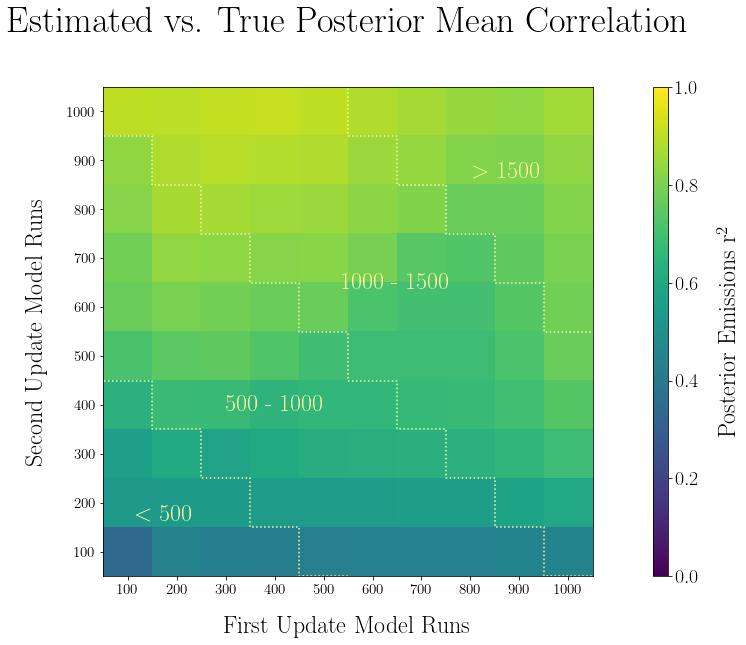

In [18]:
fig, ax = fp.get_figax()
cax = fp.add_cax(fig, ax)
ax = fp.add_title(ax, 'Estimated vs. True Posterior Mean Correlation')
# ax = fp.add_title(ax, 'Estimated DOFS')
# ax = fp.add_title(ax, 'Number of Constrained Grid Cells')

c = ax.imshow(r2_summ, vmin=0, vmax=1)
# c = ax.imshow(dofs_summ, vmin=0, vmax=270, cmap='plasma')
# c = ax.imshow(nc_summ, vmin=0, vmax=2000)
cbar = fig.colorbar(c, cax=cax)
cbar = fp.format_cbar(cbar, r'Posterior Emissions r$^2$')
# cbar = fp.format_cbar(cbar, 'DOFS')
# cbar = fp.format_cbar(cbar, 'Number of Constrained Cells')

# 1500 model run contour
ax.step(np.arange(3.5, 10.5, 1),
        np.arange(10.5, 3.5, -1),
        c=color(9), 
        ls=':')
ax.text(5.5, 5.5, '1000 - 1500', fontsize=LABEL_FONTSIZE*SCALE, color=color(9),
        ha='center', va='center')
ax.text(7.75, 7.75, r'$>$ 1500', fontsize=LABEL_FONTSIZE*SCALE, color=color(9),
        ha='center', va='center')

# 1000 model run contour
ax.step(np.arange(-1.5, 10.5, 1), 
        np.arange(10.5, -1.5, -1),
        c=color(9),
        ls=':')
ax.text(3, 3, '500 - 1000', fontsize=LABEL_FONTSIZE*SCALE, color=color(9),
        ha='center', va='center')

# 500 model run contour
ax.step(np.arange(-1.5, 5.5, 1),
        np.arange(5.5, -1.5, -1),
        c=color(9), 
        ls=':')
ax.text(0.75, 0.75, r'$<$ 500', fontsize=LABEL_FONTSIZE*SCALE, color=color(9),
        ha='center', va='center')


# Axis and tick labels
ax = fp.add_labels(ax, 'First Update Model Runs', 'Second Update Model Runs')

ax.set_xticks(np.arange(0, 10))
ax.set_xticklabels(np.arange(100, 1100, 100), fontsize=15)
ax.set_xlim(-0.5, 9.5)

ax.set_yticks(np.arange(0, 10))
ax.set_yticklabels(np.arange(100, 1100, 100), fontsize=15)
ax.set_ylim(-0.5, 9.5)

In [26]:
dofs_summ.max()

182.2518076490541

(0, 9)

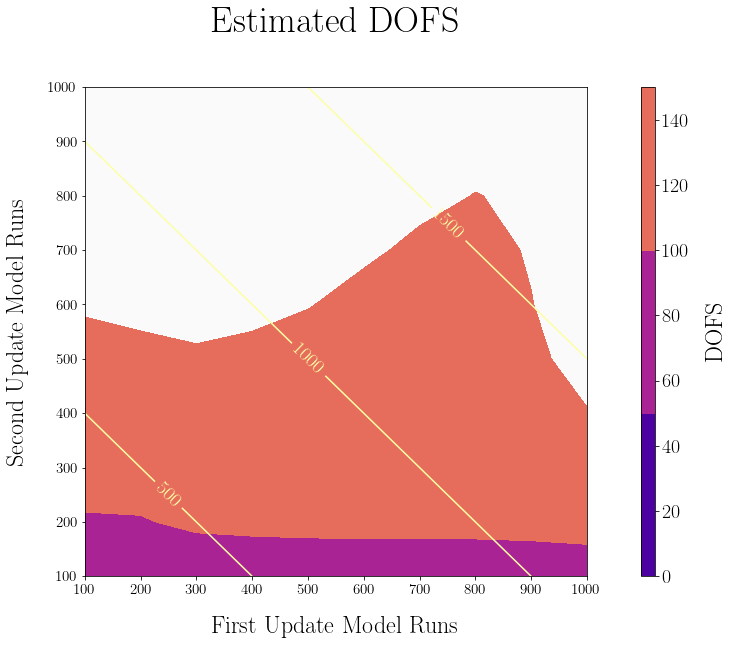

In [29]:
fig, ax = fp.get_figax()
cax = fp.add_cax(fig, ax)
# ax = fp.add_title(ax, 'Estimated vs. True Posterior Mean Correlation')
ax = fp.add_title(ax, 'Estimated DOFS')
# ax = fp.add_title(ax, 'Number of Constrained Grid Cells')

# cf = ax.contourf(r2_summ, levels=np.linspace(0, 1, 50), vmin=0, vmax=1)
cf = ax.contourf(dofs_summ, levels=np.linspace(0, 200, 50),
                 vmin=0, vmax=200, cmap='plasma')
# cf = ax.contourf(nc_summ, levels=np.arange(0, 2000, 100),
#                  vmin=0, vmax=2000)

cl = ax.contour(nm_summ, levels=3, colors=color(9))
ax.clabel(cl, cl.levels, 
          inline=True, 
          manual=[(1.5, 1.5), (4.5, 4.5), (7.5, 7.5)],
          fmt='%d', fontsize=20)

# cbar = fig.colorbar(cf, cax=cax, ticks=np.linspace(0, 1, 6))
cbar = fig.colorbar(cf, cax=cax, ticks=np.arange(0, 200, 20))
# cbar = fig.colorbar(cf, cax=cax, ticks=np.arange(0, 2000, 500))

# cbar = fp.format_cbar(cbar, r'Posterior Emissions r$^2$')
cbar = fp.format_cbar(cbar, 'DOFS')
# cbar = fp.format_cbar(cbar, 'Number of Constrained Cells')

# Axis and tick labels
ax = fp.add_labels(ax, 'First Update Model Runs', 'Second Update Model Runs')

ax.set_xticks(np.arange(0, 10))
ax.set_xticklabels(np.arange(100, 1100, 100), fontsize=15)
ax.set_xlim(0, 9)

ax.set_yticks(np.arange(0, 10))
ax.set_yticklabels(np.arange(100, 1100, 100), fontsize=15)
ax.set_ylim(0, 9)


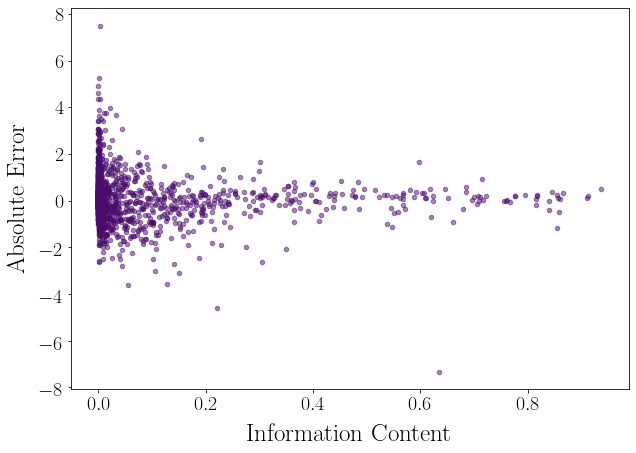

In [26]:
fig, ax = plt.subplots(figsize=(10, 7))

est2.dofs = np.diag(est2.a)

ax.scatter(est2.dofs, est2.xhat - true.xhat,
           alpha=0.5, s=5*SCALE, c=color(2))
ax.set_xlabel('Information Content', fontsize=BASEFONT+15,
              labelpad=10)
ax.set_ylabel('Absolute Error', fontsize=BASEFONT+15,
              labelpad=10)
ax.tick_params('both', labelsize=BASEFONT+10)

(0, 1)

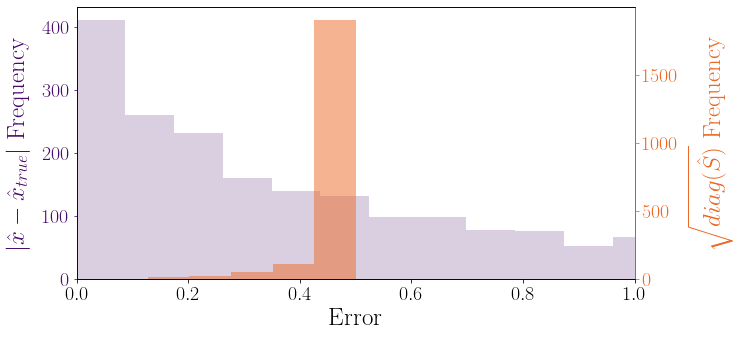

In [39]:
# plt.hist(np.diag(estab_f.shat_short), 30)
fig, ax = plt.subplots(figsize=(10, 5))

hist1 = ax.hist(np.abs(est2.xhat - true.xhat), 100, 
                color=color(2), alpha=0.2,
                label='Absolute Error of Low-Rank Posterior')
ax.spines['left'].set_color(color(2))
ax.yaxis.label.set_color(color(2))
ax.tick_params(axis='y', colors=color(2), labelsize=20)
ax.set_ylabel(r'$\vert\hat{x} - \hat{x}_{true}\vert$ Frequency', 
              fontsize=25, labelpad=10)

ax2 = ax.twinx()
hist2 = ax2.hist(np.diag(est2.shat)**0.5, 5, 
                 color=color(6), alpha=0.5,
                 label='Standard Deviation of Low-Rank Posterior')
ax2.spines['right'].set_color(color(6))
ax2.yaxis.label.set_color(color(6))
ax2.tick_params(axis='y', colors=color(6), labelsize=20)
ax2.set_ylabel(r'$\sqrt{diag(\hat{S})}$ Frequency', 
               fontsize=25, labelpad=10)

# hists = hist1 + hist2
# labels = [h.get_label() for h in hists]
# ax.legend(hists, labels);

ax.tick_params(axis='x', labelsize=20)
ax.set_xlabel('Error', fontsize=25)
ax.set_xlim(0, 1)

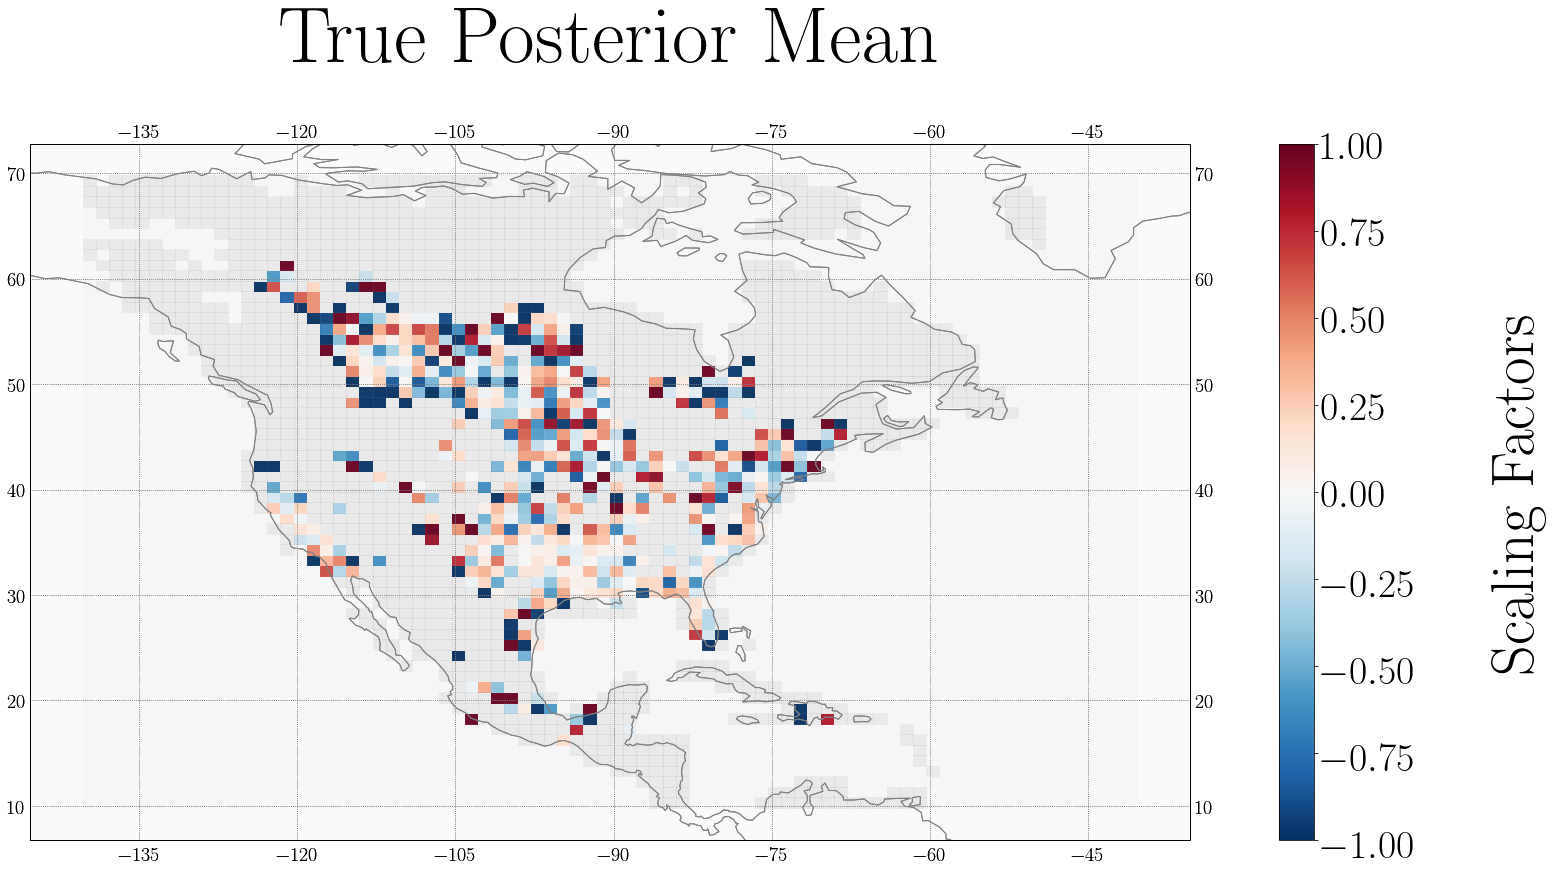

In [44]:
supy = 1.03
supsize = 100
suby = 1.05
subsize = 80
cbarsize = 50
cbarpad = 0.025

est2_f.xhat_long_diff = est2_f.xhat_long - true.xhat
est2_f.xhat_long_diff[~mask] = 0

est2_f.xhat_long_diff_rel = est2_f.xhat_long_diff/true.xhat
est2_f.xhat_long_diff_rel[~mask] = 0

fig, ax, c = est2_f.plot_state('xhat_long_diff', 
                               clusters_plot, 
                               default_value=0,
                               **{'title' : '',
                                  'cmap' : 'RdBu_r',
                                  'vmin' : -1,
                                  'vmax' : 1,
                                  'add_colorbar' : False})
c.set_label('Scaling Factors', 
            fontsize=(BASEFONT+5)*SCALE, 
            labelpad=75)

# cb = plt.colorbar(c, pad=cbarpad)
# cb.ax.tick_params(labelsize=cbarsize)

est2_f.xhat_insig = np.ones(len(est2_f.xhat_long))
est2_f.xhat_insig[mask] = 0
# clusters_mask = np.isin(clusters_plot, np.argwhere(mask).flatten())
# clusters_plot_f = copy.deepcopy(clusters_plot)
# clusters_plot_f = clusters_plot_f.where(clusters_mask, 0)
fig, ax, c  = est2_f.plot_state('xhat_insig',
                                clusters_plot,
                                default_value=0,
                                cbar=False,
                                **{'cmap' : 'Greys',
                                   'figax' : [fig, ax],
                                   'alpha' : 0.05,
                                   'title' : 'True Posterior Mean',
                                   'hatch' : '/',
                                   'add_colorbar' : False})
# # fig.suptitle('Low-Rank Posterior Mean', fontsize=supsize, y=supy)
# # ax.set_title('Model Runs = %d, Optimized Grid Cells = %d'
# #              % (est2_f.model_runs, len(est2_f.xhat)),
# #             fontsize=subsize, y = suby)

# # fig, ax, c = true.plot_state('xhat', 
# #                                clusters_plot, 
# #                                default_value=1,
# #                                **{'title' : 'True Posterior Mean',
# #                                   'cmap' : 'RdBu_r',
# #                                   'vmin' : 0,
# #                                   'vmax' : 2,
# #                                   'add_colorbar' : False})
# # cb = plt.colorbar(c, pad=cbarpad)
# # cb.ax.tick_params(labelsize=cbarsize)

# # fig.suptitle('True Posterior Mean', fontsize=supsize, y=supy)
# # ax.set_title('Model Runs = %d'
# #              % (len(true.xhat)),
# #             fontsize=subsize, y = suby)


# from matplotlib.colors import LinearSegmentedColormap

# ncolors = 300
# color_array = plt.get_cmap('plasma')(range(ncolors))

# # change alpha values
# color_array[:,-1] = np.append(np.linspace(0.0,1.0,20), np.ones(ncolors-20))

# # create a colormap object
# map_object = LinearSegmentedColormap.from_list(name='plasma_trans',colors=color_array)

# # register this new colormap with matplotlib
# plt.register_cmap(cmap=map_object)

# true.a_tr = np.diag(true.a)
# fig, ax, col = true.plot_state('a_tr', clusters_plot, 
#                              **{'title' : '',
#                                 'cmap' : 'plasma_trans',
#                                 'add_colorbar' : False,
#                                 'vmin' : 0,
#                                 'vmax' : 1})
# fig.suptitle('True Averaging Kernel', y=supy, fontsize=supsize)
# cbar = plt.colorbar(col, pad=cbarpad)
# # cbar.set_label(label=r'$\partial \hat{x}/\partial x$', 
# #                fontsize=cbarsize, x=2)
# cbar.ax.tick_params(labelsize=cbarsize)
# # cbar.set_label(label='CH4 Emissions', fontsize=16)


# # est2_f.plot_state('xhat_long',
# #                   clusters_plot,
# #                   default_)

In [37]:
len(est2_f.xhat)

606

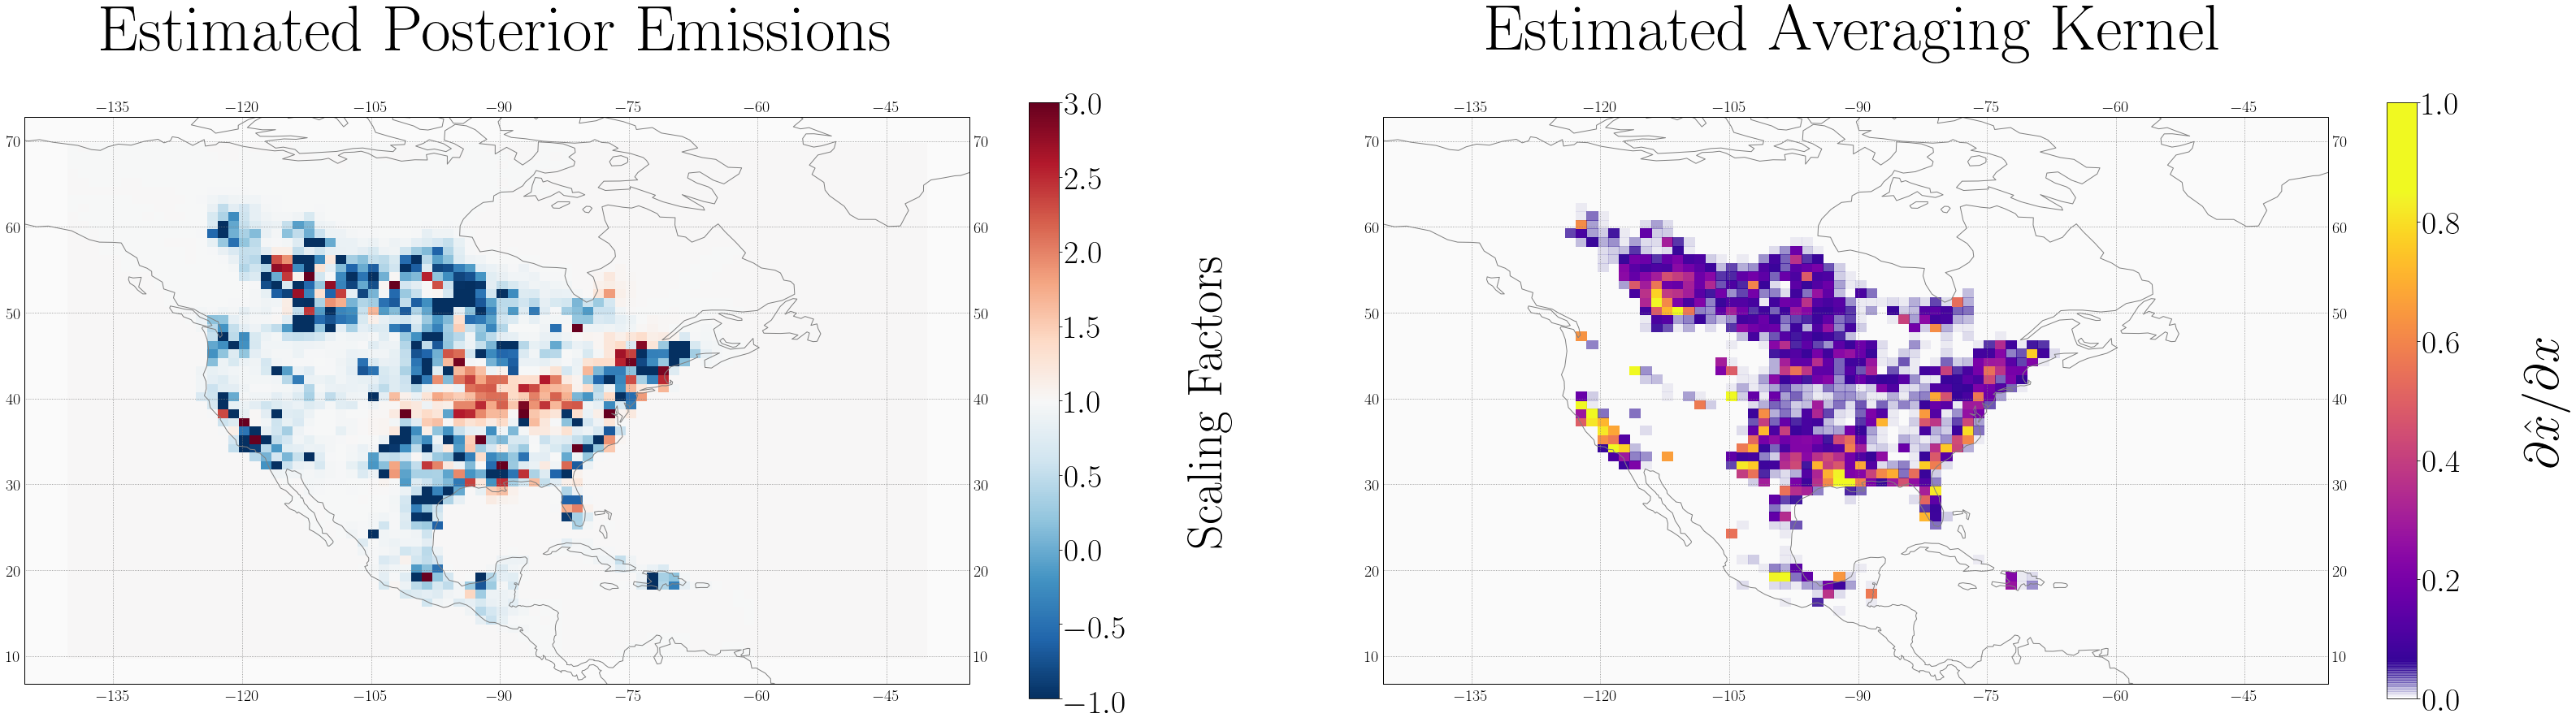

In [31]:
nx = 1
ny = 2
fig, ax = plt.subplots(nx, ny, figsize=(ny*2*7*SCALE/2, nx*6.75*SCALE/2),
                       subplot_kw={'projection' : ccrs.PlateCarree()})
plt.subplots_adjust(hspace=0.1, wspace=0.15)

fig, ax[0], c = est2.plot_state('xhat', 
                                clusters_plot, 
                                default_value=1,
                                **{'figax' : [fig, ax[0]],
                                   'title' : 'Estimated Posterior Emissions',
                                   'cmap' : 'RdBu_r',
                                   'vmin' : -1,
                                   'vmax' : 3})
c.set_label('Scaling Factors', 
            fontsize=(BASEFONT+5)*SCALE, 
            labelpad=75)

true.dofs = np.diag(true.a)
fig, ax[1], c = est2.plot_state('dofs', clusters_plot, 
                             **{'figax' : [fig, ax[1]],
                                'title' : 'Estimated Averaging Kernel',
                                'cmap' : plasma_trans,
                                'add_colorbar' : False,
                                'vmin' : 0,
                                'vmax' : 1})
c.set_label(r'$\partial\hat{x}/\partial x$',
            fontsize=(BASEFONT+5)*SCALE,
            labelpad=75)

# OLD

In [17]:
true.shatvec = np.diag(true.shat)

./python/inversion.py:518: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cax = fig.add_axes([0.95, 0.25/2, 0.01, 0.75])


Text(0.5, 1.0, 'Estimated vs. True $\\hat{S}_{K_\\pi}$')

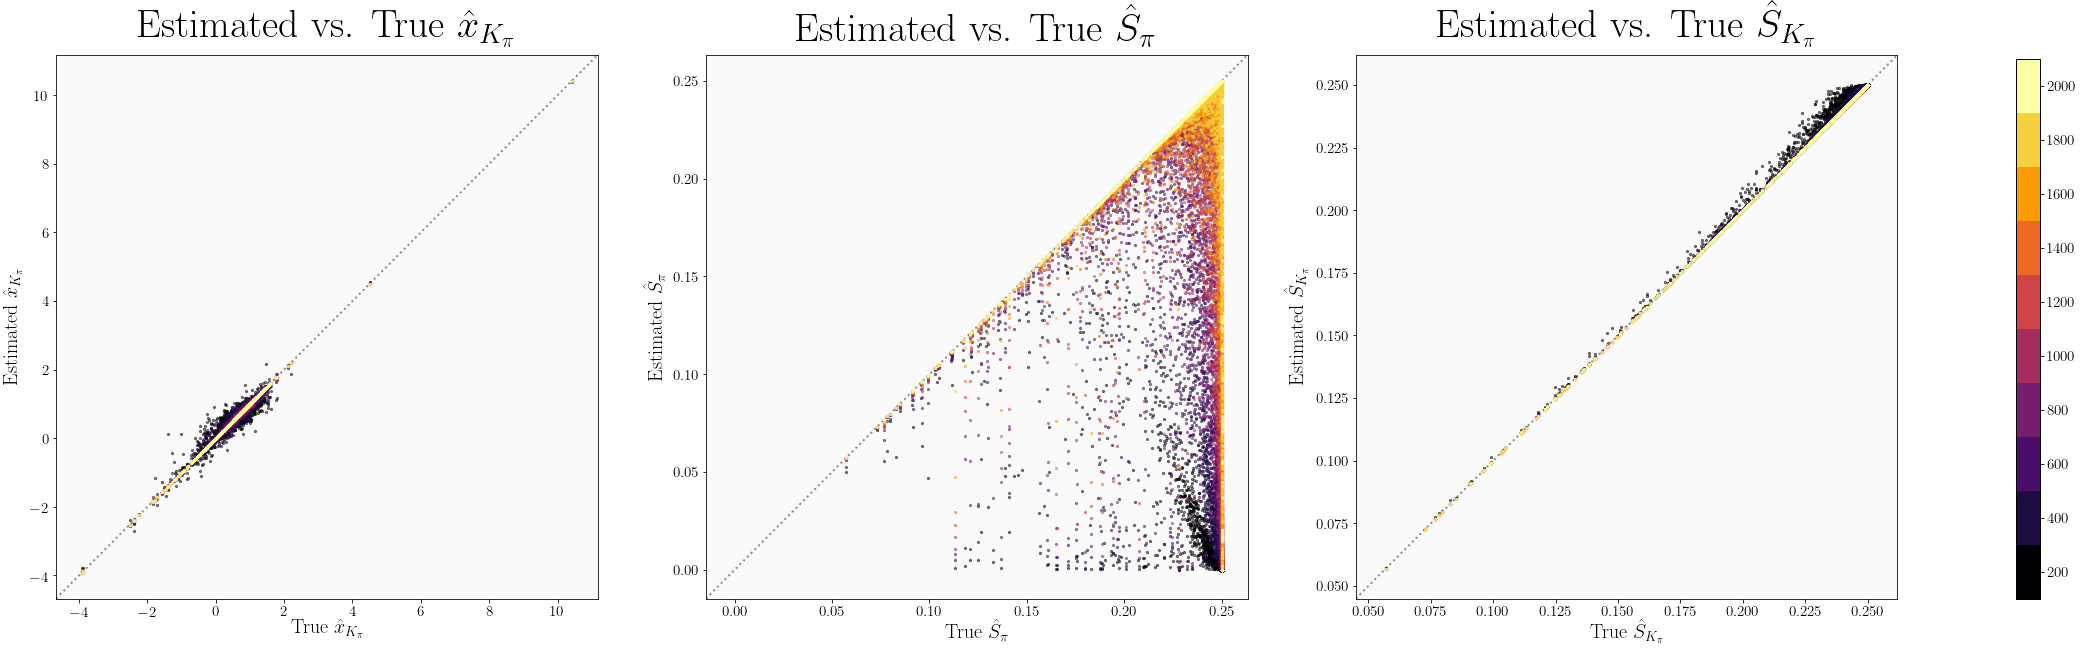

In [18]:
fig2, ax = plt.subplots(1, 3, figsize=(33, 10))
fig, ax[0] = true.plot_comparison('xhat', sol_kproj['xhat_kproj'], 
                                  **{'figax' : [fig2, ax[0]],
                                     'title' : r'Estimated vs. True $\hat{x}_{K_{\pi}}$',
                                     'xlabel' : r'True $\hat{x}_{K_\pi}$',
                                     'ylabel' : r'Estimated $\hat{x}_{K_\pi}$'})
ax[0].set_title(label=ax[0].get_title(), fontsize=40)
fig, ax[1] = true.plot_comparison('shatvec', sol_kproj['shat_proj'], 
                                  **{'figax' : [fig2, ax[1]],
                                     'title' : r'Estimated vs. True $\hat{S}_{\pi}$',
                                     'xlabel' : r'True $\hat{S}_{\pi}$',
                                     'ylabel' : r'Estimated $\hat{S}_{\pi}$'})
ax[1].set_title(label=ax[1].get_title(), fontsize=40)
fig, ax[2] = true.plot_comparison('shatvec', sol_kproj['shat_kproj'], 
                                  **{'figax' : [fig2, ax[2]],
                                     'title' : r'Estimated vs. True $\hat{S}_{K_\pi}$',
                                     'xlabel' : r'True $\hat{S}_{K_\pi}$',
                                     'ylabel' : r'Estimated $\hat{S}_{K_\pi}$'})
ax[2].set_title(label=ax[2].get_title(), fontsize=40)

# cbar = fig.axes[-1]
# cbar.set_ylabel('Rank', fontsize=40)
# cbar.tick_params(labelsize=40)
# true.plot_comparison('a', np.diag(sol_kproj['a_kproj']), 
#                      **{'figax' : [fig2, ax[3]]})

# Improving the Initial Estimate: Multiscale Grid

In [24]:
# I want to try a range of n_cells--but since the idea is to minimize 
# computational cost, the goal here is to keep the number of model runs
# < 1/4 of the full number of model runs (at least for now). I will 
# test a range of n_cells/n_cluster_size combinations, but with the 
# goal of limiting the number of model runs to < 500 (and preferably
# fewer, to support iteration)

# To start with, let's see what we can do with 200 model runs. That
# way we have space to iterate.

# We also want to test whether it's better to use the previous estimate
# of K or an array of zeros as the basis.

# First, we test keeping high resolution for all 200 grid cells.
# test1 = est0.update_jacobian_ag(forward_model=true.k, 
#                                 clusters_plot=clusters_plot, 
#                                 pct_of_info=1,
#                                 n_cells=[2098],
#                                 n_cluster_size=[1],
#                                )
# test1.full_analysis(true, clusters_plot)


# First, we test if Broyden's matrix works if we perturb each and 
# every grid cell--it should. This is a test of code.
pert_matrix = np.identity(est0.nstate)
k_base = np.zeros(est0.k.shape)
new = inv.ReducedRankJacobian(k=k_base,
                          xa=copy.deepcopy(est0.xa),
                          sa_vec=copy.deepcopy(est0.sa_vec),
                          y=copy.deepcopy(est0.y),
                          y_base=copy.deepcopy(est0.y_base),
                          so_vec=copy.deepcopy(est0.so_vec))

new.broyden(true.k, pert_matrix)

Calculated rank from rank threshold: 175
Number of clusters: 100
Cluster size: 1
Maximum number of grid boxes in a cluster: 1
Number of clusters: 100
Cluster size: 2
Maximum number of grid boxes in a cluster: 5
Number of state vector elements: 200
Calculated PPH.
Eigendecomposition complete.
Negative eigenvalues. Maximum negative value is -1.16e-14. Setting negative eigenvalues to zero.
Saving eigenvalues and eigenvectors to instance.
Calculating the cost function at the prior mean.
     Cost function: 59517.59
Calculating the posterior error.
Calculating the posterior mean.
Calculating the cost function at the posterior mean.
     Cost function: 41041.34
     Negative cells: -129
Calculating the averaging kernel.
     DOFS: 62.17
Calculating updated modeled observations.
Inversion complete.


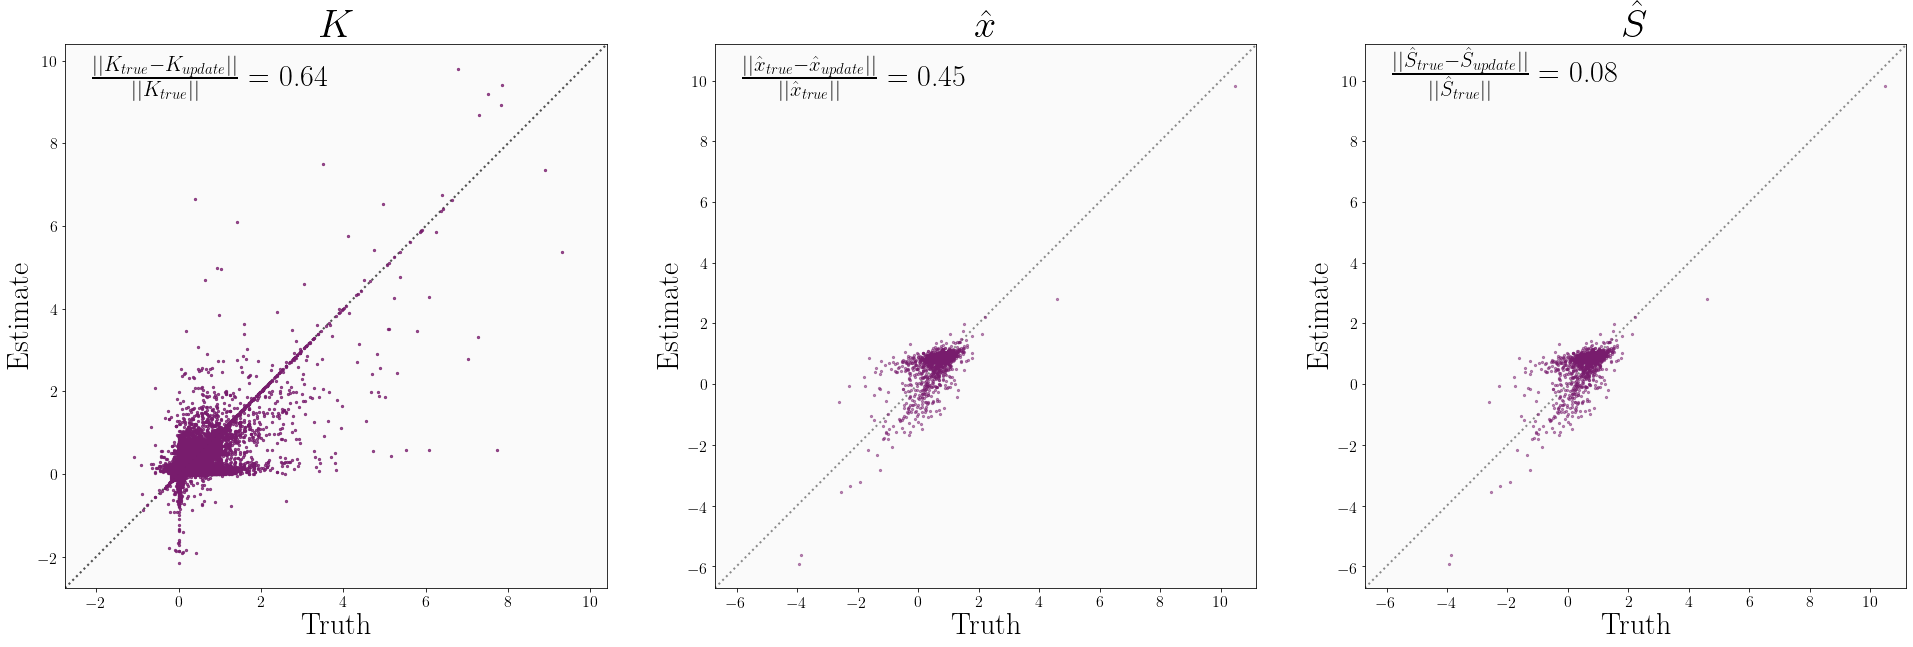

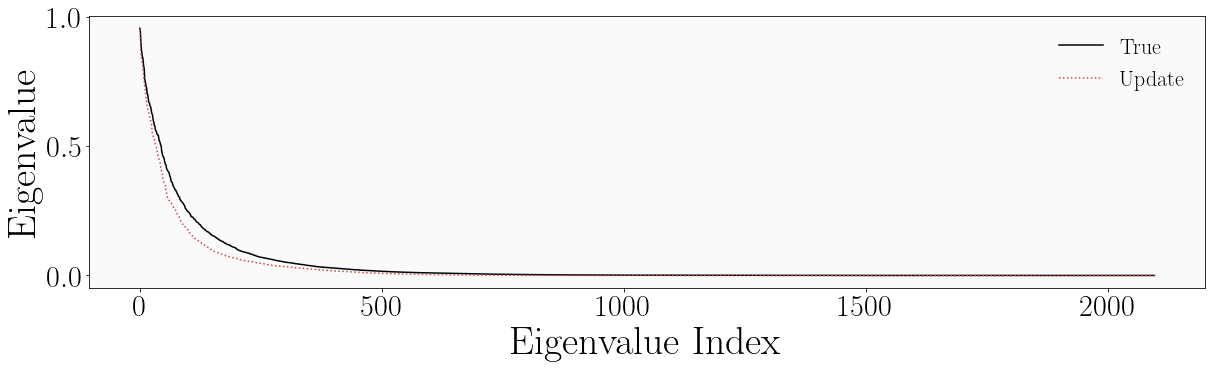

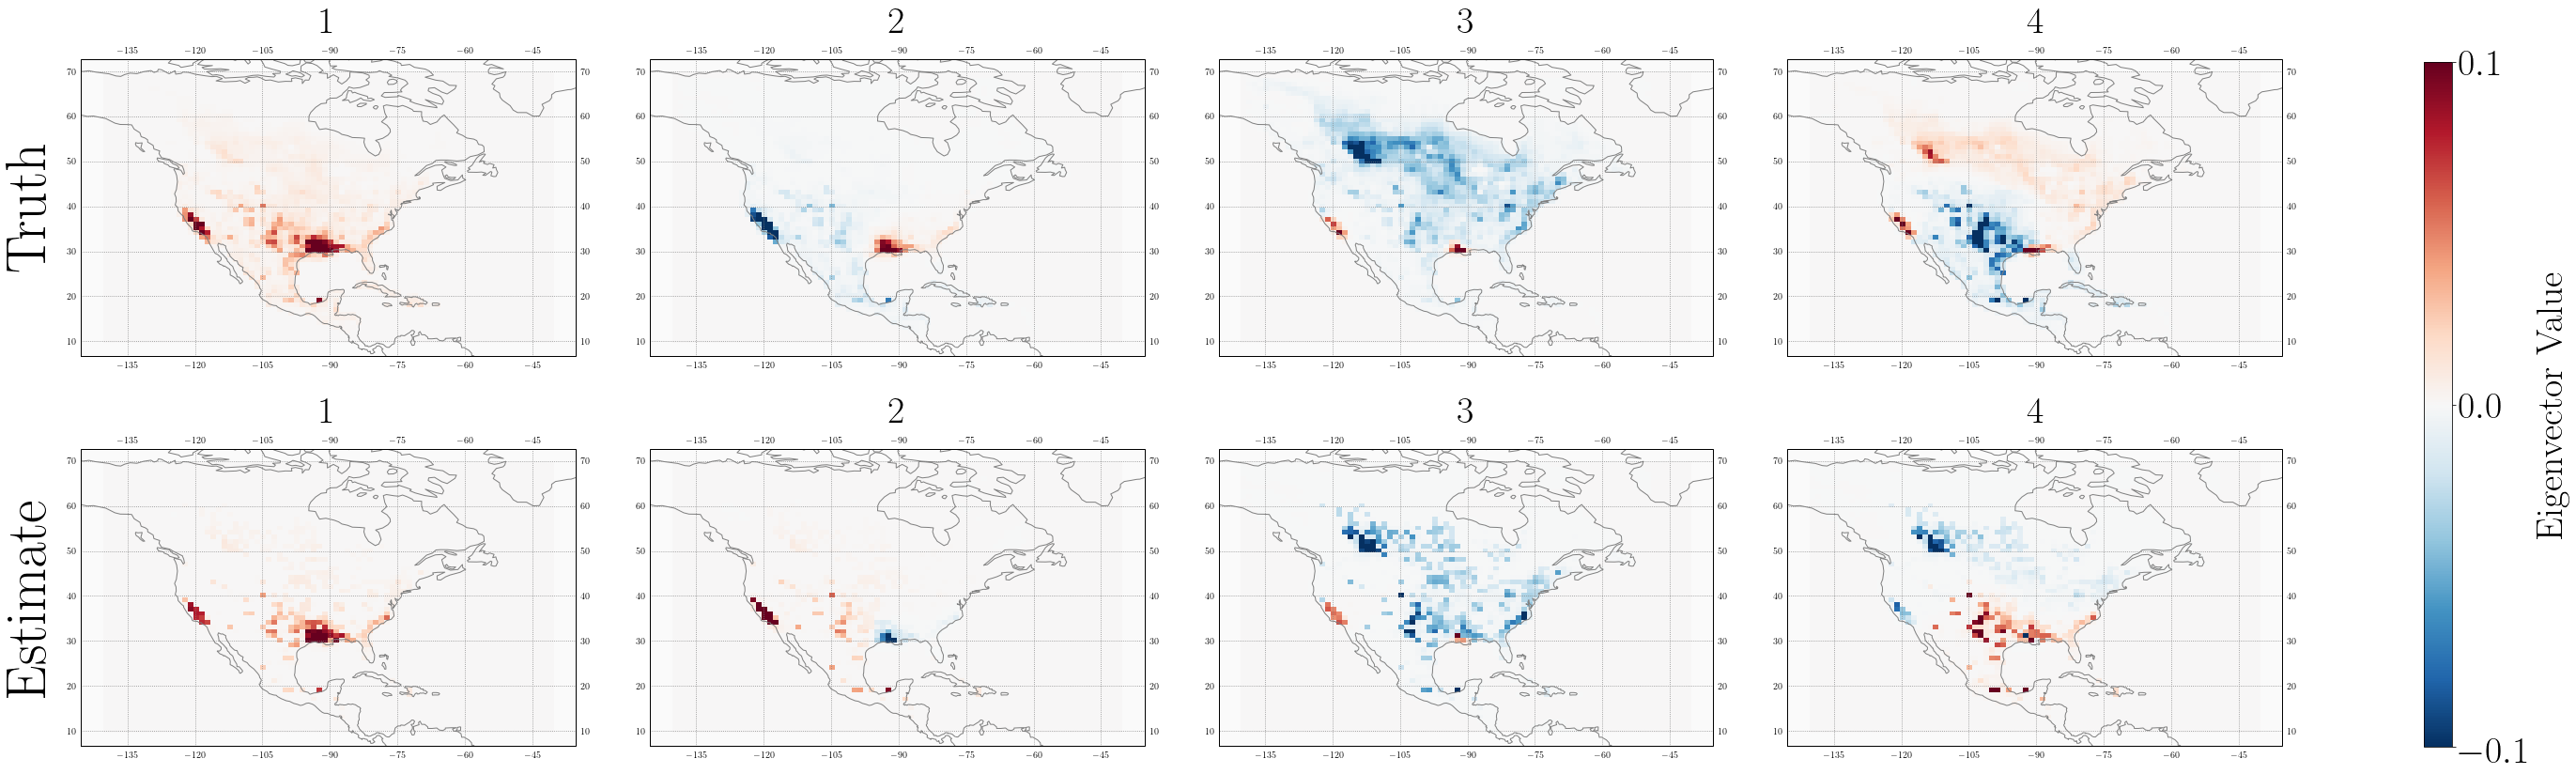

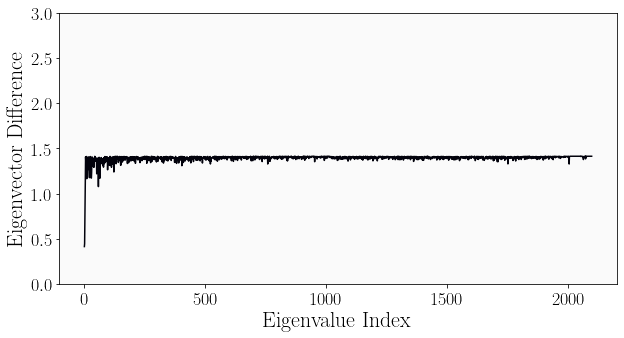

In [22]:
# Then, we test keeping high resolution for the top 100 cells
# and going to coarser resolution elsewhere.
test2 = est0.update_jacobian_ag(forward_model=true.k, 
                             clusters_plot=clusters_plot, 
                             pct_of_info=0.9,
                             n_cells=[100, 200],
                             n_cluster_size=[1, 2])
test2.full_analysis(true, clusters_plot)